## **Introduction**  
   #### * Merge multi-source data, find and fill missing values and outliers  
   #### * Clarify business logic during data cleaning, and select a reasonable time period for analysis
   #### * Perform multi-dimensional exploratory data analysis (EDA) and visualize results  
   #### * Analyze key metrics in the business process using the AARRR model
   #### * Use RFM + K-means to analyze user behavior, segment users, and provide targeted growth strategies

## **Data Import and Processing**

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

# Define dataset paths
dfs_paths = ["olist_customers_dataset.csv", "olist_geolocation_dataset.csv",
            "olist_order_items_dataset.csv", "olist_order_payments_dataset.csv",
            "olist_order_reviews_dataset.csv", "olist_orders_dataset.csv",
            "olist_products_dataset.csv", "olist_sellers_dataset.csv",
            "product_category_name_translation.csv"]

# Read datasets
customers = pd.read_csv("olist_customers_dataset.csv")
geolocation = pd.read_csv("olist_geolocation_dataset.csv")
order_items= pd.read_csv("olist_order_items_dataset.csv")
payments = pd.read_csv("olist_order_payments_dataset.csv")
reviews = pd.read_csv("olist_order_reviews_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")
category_translation = pd.read_csv("product_category_name_translation.csv")

# Set DataFrame display option to show all columns
pd.set_option('display.max_columns', 500)

### **Initial Data Check and Missing Value Detection**

In [2]:
# Display first five rows and info for each table
for df, name in zip([customers, orders, order_items, payments, reviews, products, sellers, geolocation, category_translation],
                    ['customers', 'orders', 'order_items', 'payments', 'reviews', 'products', 'sellers', 'geolocation', 'category_translation']):
    print(f"--- {name} ---")
    print(df.head(3))
    print(df.info())
    print('\n')

--- customers ---
                        customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 no

In [3]:
# Missing value statistics
for df, name in zip([customers, orders, order_items, payments, reviews, products, sellers, geolocation, category_translation],
                    ['customers', 'orders', 'order_items', 'payments', 'reviews', 'products', 'sellers', 'geolocation', 'category_translation']):
    missing = df.isnull().sum()
    print(f"{name} missing value statistics:\n{missing[missing>0]}\n")

customers missing value statistics:
Series([], dtype: int64)

orders missing value statistics:
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
dtype: int64

order_items missing value statistics:
Series([], dtype: int64)

payments missing value statistics:
Series([], dtype: int64)

reviews missing value statistics:
review_comment_title      87656
review_comment_message    58247
dtype: int64

products missing value statistics:
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

sellers missing value statistics:
Series([], dtype: int64)

geolocation missing value statistics:
Series([], dtype: int64)

category_translation missing value statistics:
Series([], dtype: int64)




##### **1. Missing values in orders table**      
**order_approved_at, order_delivered_carrier_date, order_delivered_customer_date are missing, representing order confirmation, shipping, and delivery times. Missing values may indicate incomplete or cancelled orders. Check with order_status field. No filling or deletion for now.**
##### **2. Missing values in reviews table**      
**Represents orders without comments, but review_score is complete. Only text comments are missing, which is normal and does not require filling or deletion.**
##### **3. Missing values in products table**      
**product_category_name, product_name_length, product_description_length, product_photos_qty are missing for some products. If needed, fill with 'unknown'.**


### **Time Field Format Conversion**

In [4]:
time_cols_orders = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
for col in time_cols_orders:
    orders[col] = pd.to_datetime(orders[col], errors='coerce')  # errors='coerce' will convert invalid times to NaT

time_cols_reviews = ['review_creation_date', 'review_answer_timestamp']
for col in time_cols_reviews:
    reviews[col] = pd.to_datetime(reviews[col], errors='coerce')

### **Anomaly Detection: Duplicate Value Check and Handling**

In [5]:
# Check for duplicate order IDs. Normally, order_id should be unique. If duplicates exist, investigate further.
print(f"Number of duplicate order IDs in orders: {orders['order_id'].duplicated().sum()}")

Number of duplicate order IDs in orders: 0


### **Multi-table Join:**
**customers+orders+payments+reviews+order_items+products+seller+geo+category**

#### **(1) customers+geolocation**

In [6]:
# First, link customer city in customers to geo to get corresponding latitude and longitude
import pandas as pd

# 1. Aggregate geolocation by zip_code_prefix, calculate mean latitude/longitude, keep mode or first value for city/state
geolocation_agg = geolocation.groupby('geolocation_zip_code_prefix').agg({
    'geolocation_lat': 'mean',
    'geolocation_lng': 'mean',
    'geolocation_city': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    'geolocation_state': lambda x: x.mode().iloc[0] if not x.mode().empty else None
}).reset_index()

# 2. Left join customers with aggregated geolocation info
customers_geo = customers.merge(
    geolocation_agg,
    left_on='customer_zip_code_prefix',
    right_on='geolocation_zip_code_prefix',
    how='left'
)
customers_geo = customers_geo.drop(columns=['geolocation_zip_code_prefix', 'geolocation_city', 'geolocation_state'])
# 3. View merge result
print(customers_geo.shape) 
print(customers_geo.head(3))

(99441, 7)
                        customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   

   customer_zip_code_prefix          customer_city customer_state  \
0                     14409                 franca             SP   
1                      9790  sao bernardo do campo             SP   
2                      1151              sao paulo             SP   

   geolocation_lat  geolocation_lng  
0       -20.498489       -47.396929  
1       -23.727992       -46.542848  
2       -23.531642       -46.656289  


In [7]:
missing_counts = customers_geo.isnull().sum()
missing_percent = (missing_counts / len(customers_geo)) * 100
missing_df = pd.DataFrame({'Missing Count': missing_counts, 'Missing Percentage (%)': missing_percent})
print(missing_df)

                          Missing Count  Missing Percentage (%)
customer_id                           0                0.000000
customer_unique_id                    0                0.000000
customer_zip_code_prefix              0                0.000000
customer_city                         0                0.000000
customer_state                        0                0.000000
geolocation_lat                     278                0.279563
geolocation_lng                     278                0.279563


**Missing values are due to missing latitude/longitude in the geolocation table and should be supplemented in the database.**

#### **(2) customers+geolocation+orders**

In [8]:
# With customers_geo table, now link customers to their orders
# Left join orders and customers_geo on customer_id
orders_customers_geo = orders.merge(customers_geo, on='customer_id', how='left')

print(f"orders_customers_geo row count: {orders_customers_geo.shape[0]}")  # Should equal orders row count
print(orders_customers_geo.head())

orders_customers_geo row count: 99441
                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-

#### **（3）customers+geolocation+orders+payments**

In [9]:
# 1. Aggregate payments by order_id, calculate payment count, total installments, total payment
payments_agg = payments.groupby('order_id').agg(
    payment_count = ('payment_sequential', 'count'),
    installments_sum = ('payment_installments', 'sum'),
    payment_total = ('payment_value', 'sum')
).reset_index()

# 2. Left join orders_customers_geo with aggregated payments
df_orders_payments = orders_customers_geo.merge(payments_agg, on='order_id', how='left')

# 3. Handle missing values (fill 0 for orders without payment records)
df_orders_payments['payment_count'] = df_orders_payments['payment_count'].fillna(0).astype(int)
df_orders_payments['installments_sum'] = df_orders_payments['installments_sum'].fillna(0).astype(int)
df_orders_payments['payment_total'] = df_orders_payments['payment_total'].fillna(0)

# 4. View result
print(df_orders_payments[['order_id', 'payment_count', 'installments_sum', 'payment_total']].head())
print(f"Total orders: {df_orders_payments.shape[0]}")

                           order_id  payment_count  installments_sum  \
0  e481f51cbdc54678b7cc49136f2d6af7              3                 3   
1  53cdb2fc8bc7dce0b6741e2150273451              1                 1   
2  47770eb9100c2d0c44946d9cf07ec65d              1                 3   
3  949d5b44dbf5de918fe9c16f97b45f8a              1                 1   
4  ad21c59c0840e6cb83a9ceb5573f8159              1                 1   

   payment_total  
0          38.71  
1         141.46  
2         179.12  
3          72.20  
4          28.62  
Total orders: 99441


**Check for abnormal data in the table, such as installment count less than payment count. Normally, installment count should be >= payment count.**  
    **If this issue exists, set installments_sum equal to payment_count.**

In [10]:
# Filter abnormal orders where installments_sum < payment_count
abnormal_installments = df_orders_payments[df_orders_payments['installments_sum'] < df_orders_payments['payment_count']]
# View count and sample of abnormal orders
print(f"Number of abnormal orders: {abnormal_installments.shape[0]}")
print(abnormal_installments[['order_id', 'payment_count', 'installments_sum', 'payment_total']].head(10))

Number of abnormal orders: 2
                               order_id  payment_count  installments_sum  \
63782  744bade1fcf9ff3f31d860ace076d422              1                 0   
66368  1a57108394169c0b47d8f876acc9ba2d              1                 0   

       payment_total  
63782          58.69  
66368         129.94  


In [11]:
# Make corrections
abnormal_order_ids = abnormal_installments['order_id'].tolist()
# Set payment_installments to 1 for all payments of abnormal orders so sum equals payment_count
payments.loc[payments['order_id'].isin(abnormal_order_ids), 'payment_installments'] = 1

payments_agg_fixed = payments.groupby('order_id').agg(
    payment_count = ('payment_sequential', 'count'),
    installments_sum = ('payment_installments', 'sum'),
    payment_total = ('payment_value', 'sum')
).reset_index()
df_orders_payments_fixed = orders_customers_geo.merge(payments_agg_fixed, on='order_id', how='left')

# Check if abnormalities remain
abnormal_after_fix = df_orders_payments_fixed[df_orders_payments_fixed['installments_sum'] < df_orders_payments_fixed['payment_count']]
print(f"Number of abnormal orders after correction: {abnormal_after_fix.shape[0]}")

# Output corrected abnormal orders (should be zero)
print(df_orders_payments_fixed.loc[df_orders_payments_fixed['order_id'].isin(abnormal_order_ids),
                                  ['order_id', 'payment_count', 'installments_sum', 'payment_total']].head(10))


Number of abnormal orders after correction: 0
                               order_id  payment_count  installments_sum  \
63782  744bade1fcf9ff3f31d860ace076d422            1.0               1.0   
66368  1a57108394169c0b47d8f876acc9ba2d            1.0               1.0   

       payment_total  
63782          58.69  
66368         129.94  


#### **(4) customers+geolocation+orders+payments+reviews**

One order_id may correspond to multiple review_id, i.e., one order may have multiple reviews. Focus on mean(review_score) for the same order, and the earliest review and reply times.

In [12]:
# 1. Convert time fields to datetime type
reviews['review_creation_date'] = pd.to_datetime(reviews['review_creation_date'])
reviews['review_answer_timestamp'] = pd.to_datetime(reviews['review_answer_timestamp'])

# 2. Aggregate reviews table
reviews_agg = reviews.groupby('order_id').agg({
    'review_score': 'mean',
    'review_creation_date': 'min',
    'review_answer_timestamp': 'min'
}).reset_index()

# 3. Merge with order payments table
df_final = df_orders_payments_fixed.merge(reviews_agg, on='order_id', how='left')

# 4. Handle missing values
df_final['review_score'] = df_final['review_score'].fillna(0)
df_final['review_creation_date'] = df_final['review_creation_date'].fillna(pd.NaT)
df_final['review_answer_timestamp'] = df_final['review_answer_timestamp'].fillna(pd.NaT)

# 5. View result
print(df_final[['order_id', 'review_score', 'review_creation_date', 'review_answer_timestamp']].head(10))
print(f"Final data table row count: {df_final.shape[0]}")


                           order_id  review_score review_creation_date  \
0  e481f51cbdc54678b7cc49136f2d6af7           4.0           2017-10-11   
1  53cdb2fc8bc7dce0b6741e2150273451           4.0           2018-08-08   
2  47770eb9100c2d0c44946d9cf07ec65d           5.0           2018-08-18   
3  949d5b44dbf5de918fe9c16f97b45f8a           5.0           2017-12-03   
4  ad21c59c0840e6cb83a9ceb5573f8159           5.0           2018-02-17   
5  a4591c265e18cb1dcee52889e2d8acc3           4.0           2017-07-27   
6  136cce7faa42fdb2cefd53fdc79a6098           2.0           2017-05-13   
7  6514b8ad8028c9f2cc2374ded245783f           5.0           2017-05-27   
8  76c6e866289321a7c93b82b54852dc33           1.0           2017-02-03   
9  e69bfb5eb88e0ed6a785585b27e16dbf           5.0           2017-08-17   

  review_answer_timestamp  
0     2017-10-12 03:43:48  
1     2018-08-08 18:37:50  
2     2018-08-22 19:07:58  
3     2017-12-05 19:21:58  
4     2018-02-18 13:02:51  
5     2017-07-27 

#### **(5) customers+geolocation+orders+payments+reviews+items+products+sellers**

In [13]:
# Use left join on order_id to expand order-level info to each item
df_merged = order_items.merge(df_final, on='order_id', how='left')

# Left join with products table on product_id to get product details
df_items_products = df_merged.merge(products, on='product_id', how='left')

# Translate category from Portuguese to English using translation table
# Join with category_translation table to translate product category to English
df_items_products = df_items_products.merge(category_translation, on='product_category_name', how='left')

# View merge result
print(f"Rows after merge: {df_items_products.shape[0]}, Columns: {df_items_products.shape[1]}")

Rows after merge: 112650, Columns: 35


In [14]:
# Finally, add seller info by joining with sellers table
df_full = df_items_products.merge(sellers, on='seller_id', how='left')
# Check for missing seller_id
print(df_full['seller_id'].isnull().sum())  # Should be 0
# Check final table row count; should match items table except for one-to-many matches
print(df_items_products.shape[0], df_full.shape[0])


0
112650 112650


#### **Final Complete Table Information and Adjustments**

In [15]:
df_final = df_full



print(df_final.head())
print(df_final.columns.tolist())

# Calculate missing value count and ratio
missing_count = df_final.isnull().sum()
missing_ratio = df_final.isnull().mean()

# Combine into a DataFrame
missing_df = pd.DataFrame({
    'missing_count': missing_count,
    'missing_ratio': missing_ratio
}).sort_values(by='missing_ratio', ascending=False)

# Display result
print(f"Total columns: {missing_df.shape[0]}")
print(missing_df)


                           order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

   shipping_limit_date   price  freight_value  \
0  2017-09-19 09:45:35   58.90          13.29   
1  2017-05-03 11:05:13  239.90          19.93   
2  2018-01-18 14:48:30  199.00          17.87   
3  2018-08-15 10:10:18   12.99          

## **Exploratory Data Analysis**

### **1. Customer Behavior Analysis**

##### **(1) Customer Geographic Distribution**

#### **1. Geographic Distribution**
    Visualize customers by state, city, and zip code using geographic data
    Use unique customer_unique_id for true customer count in the distribution map

In [16]:
# Import packages
import pandas as pd
import folium
from folium.plugins import MarkerCluster

# Load data from olist_geolocation_dataset and olist_customers_dataset

df_customers = pd.read_csv("olist_customers_dataset.csv")
df_geo = pd.read_csv("olist_geolocation_dataset.csv")
# Remove duplicates to get unique customers
df_unique_customers = df_customers.drop_duplicates(subset='customer_unique_id')

# Count customers per zip code area
# Group by customer zip code prefix
zip_customer_count = (
    df_unique_customers
    .groupby('customer_zip_code_prefix')
    .size()
    .reset_index(name='customer_count')
)

# Use mean latitude/longitude for each zip code as area center
zip_geo = (
    df_geo
    .groupby('geolocation_zip_code_prefix')[['geolocation_lat', 'geolocation_lng']]
    .mean()
    .reset_index()
)

# Merge customer count with latitude/longitude
# Merged table has prefix, lat, lng; remove missing values
df_zip_map = zip_customer_count.merge(
    zip_geo,
    left_on='customer_zip_code_prefix',
    right_on='geolocation_zip_code_prefix',
    how='left'
).dropna(subset=['geolocation_lat', 'geolocation_lng'])

# Create map centered at mean location of all zip codes
map_center = [df_zip_map['geolocation_lat'].mean(), df_zip_map['geolocation_lng'].mean()]
m = folium.Map(location=map_center, zoom_start=4)

# Add marker cluster to prevent overlapping points
# MarkerCluster automatically merges nearby markers
# Merges when zoomed out, splits when zoomed in for better visualization
marker_cluster = MarkerCluster().add_to(m)

for idx, row in df_zip_map.iterrows():
    folium.CircleMarker(
        location=[row['geolocation_lat'], row['geolocation_lng']],
        radius=min(row['customer_count'] ** 0.5, 10),  # Control point size (square root scaling)
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        popup=f"Zip code: {row['customer_zip_code_prefix']}<br>Customer count: {row['customer_count']}"
    ).add_to(marker_cluster)

# Save map
from IPython.display import IFrame
map_file = 'customer_distribution_by_zip.html'
m.save(map_file)
IFrame(map_file, width=1200, height=600)

Display the distribution of customers/orders in each zip code area (based on unique customer ID), and visualize the location clustering nationwide:

    (1) Understand the density of customer geographic distribution, useful for market analysis and regional strategy development

    (2) Assist in regional market strategy, helpful for targeted marketing and sales network planning

    (3) According to the density of customer geographic distribution, consider warehouse location selection and new warehouse construction, improve delivery efficiency, set up transit nodes, support operational expansion, improve customer satisfaction, and reduce costs.

##### **(2) Order Geographic Distribution (Delivery Location)**

In [18]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster

# Remove orders with missing latitude/longitude to avoid errors when aggregating by location
df_valid = df_final.dropna(subset=['geolocation_lat', 'geolocation_lng'])

# Create Folium map
m = folium.Map(location=[-15.788497, -47.879873], zoom_start=4)

# Create MarkerCluster (aggregator)
marker_cluster = MarkerCluster().add_to(m)

# Iterate through orders, one point per order
for _, row in df_valid.iterrows():
    folium.CircleMarker(
        location=[row['geolocation_lat'], row['geolocation_lng']],
        radius=2,
        popup=f"Order ID: {row['order_id']}<br>Zip Code Prefix: {row['customer_zip_code_prefix']}",
        color='green',
        fill=True,
        fill_opacity=0.5
    ).add_to(marker_cluster)

# Save and display map
from IPython.display import IFrame
map_file = 'order_distribution_map.html'
m.save(map_file)
IFrame(map_file, width=1200, height=600)

#### **2. Customer Orders**
    Customer order revenue = average order price * number of orders
##### **(1) Number of Orders per Customer**
How many orders did each customer (customer_unique_id) place? Top 20 customers by order count.
Note: Remove duplicates, as joining tables may cause repeated order_id rows due to multiple items per order.

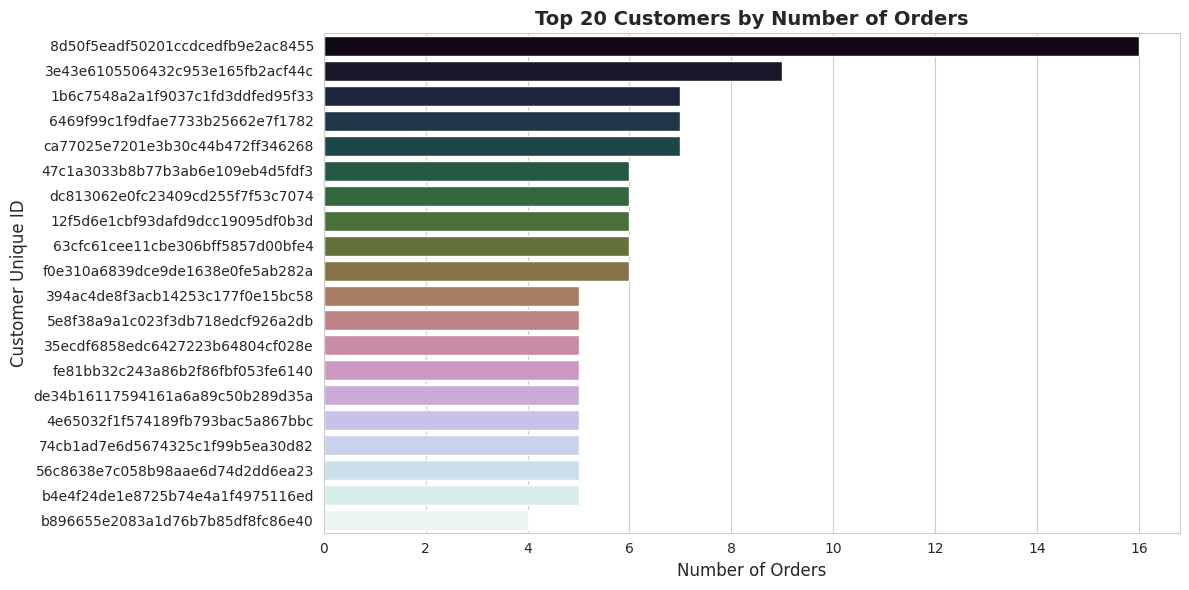

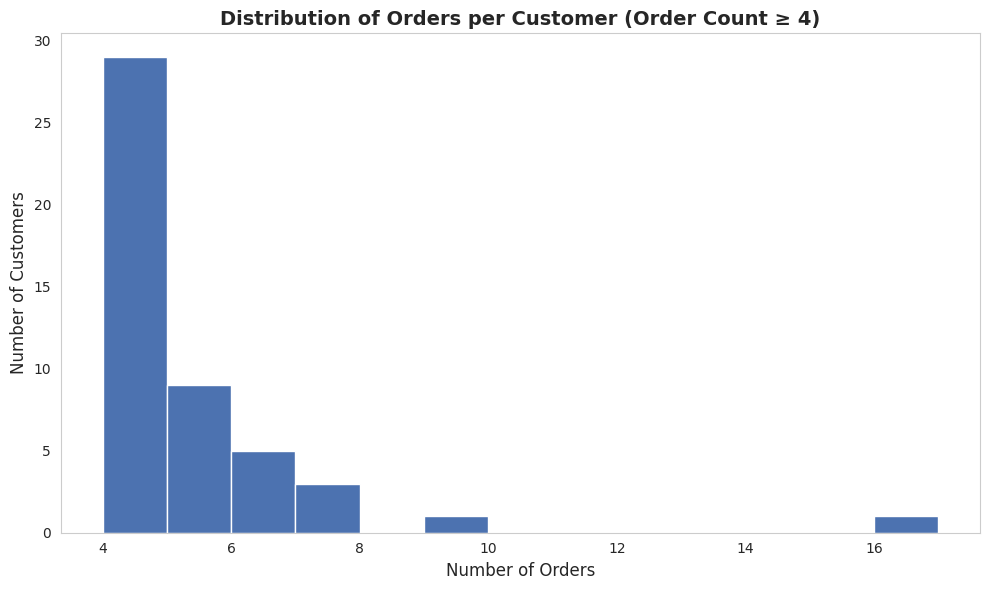

In [ ]:
'''
Mysql:
select customer_unique_id, count(distinct order_id)
from df_final
group by customer_unique_id
order by count(distinct order_id) desc
'''

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_orders_per_customer = df_final.groupby('customer_unique_id')['order_id'].nunique().reset_index()
df_orders_per_customer.columns = ['customer_unique_id', 'order_count']

# Top 20 customers by order count
top_customers = df_orders_per_customer.sort_values('order_count', ascending=False).head(20)
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.barplot(
    x='order_count',
    y='customer_unique_id',
    data=top_customers,
    palette='cubehelix'  
)
plt.title("Top 20 Customers by Number of Orders", fontsize=14, fontweight='bold')
plt.xlabel("Number of Orders", fontsize=12)
plt.ylabel("Customer Unique ID", fontsize=12)
plt.tight_layout()
plt.show()

# Order count distribution chart: since most people only order once, direct visualization makes other bars too low to see
# Therefore, only visualize customers with order count >= 4; see table for specific numbers
# Filter customers with order count >= 4
filtered = df_orders_per_customer[df_orders_per_customer['order_count'] >= 4]

plt.figure(figsize=(10, 6))
plt.hist(filtered['order_count'], bins=range(4, filtered['order_count'].max() + 2), color='#4C72B0', edgecolor='white')
plt.title("Distribution of Orders per Customer (Order Count ≥ 4)", fontsize=14, fontweight='bold')
plt.xlabel("Number of Orders", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)
plt.grid(False)
plt.tight_layout()
plt.show()


##### **(2) Distribution of Customer Order Amounts** 

In [ ]:
import pandas as pd

# Aggregate by order ID, calculate total price and freight
order_agg = df_final.groupby('order_id').agg({
    'price': 'sum',
    'freight_value': 'sum'
}).reset_index()
order_agg['order_total_price'] = order_agg['price'] + order_agg['freight_value']

# Define amount intervals and segment
bins = [0, 50, 100, 200, 500, 1000, 5000, 10000, order_agg['order_total_price'].max() + 1]
labels = ['0-50', '50-100', '100-200', '200-500', '500-1000', '1000-5000', '5000-10000', '10000+']
order_agg['amount_range'] = pd.cut(order_agg['order_total_price'], bins=bins, labels=labels, right=False)

# Count orders and percentage in each interval
range_counts = order_agg['amount_range'].value_counts().sort_index()
range_ratio = (range_counts / range_counts.sum() * 100).round(2)

# Combine into summary table
summary_table = pd.DataFrame({
    'Amount Range': range_counts.index,
    'Order Count': range_counts.values,
    'Percentage (%)': range_ratio.values
})

# Add mean row
mean_order_count = summary_table['Order Count'].mean().round(2)
mean_percentage = summary_table['Percentage (%)'].mean().round(2)

summary_table_with_mean = pd.concat([
    summary_table,
    pd.DataFrame([{
        'Amount Range': 'Mean',
        'Order Count': mean_order_count,
        'Percentage (%)': mean_percentage
    }])
], ignore_index=True)

# Highlight mean row function
def highlight_mean_row(row):
    return ['background-color: #FFF8DC' if row['Amount Range'] == 'Mean' else '' for _ in row]

# Style formatting
styled_table = summary_table_with_mean.style \
    .apply(highlight_mean_row, axis=1) \
    .background_gradient(subset=['Percentage (%)'], cmap='Greys') \
    .bar(subset=['Order Count'], color='#6A5D7B') \
    .format({
        'Order Count': '{:,.2f}',
        'Percentage (%)': '{:.2f}%'
    }) \
    .set_caption("Order Amount Interval Statistics Table (with Mean)") \
    .set_table_styles([
        {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-weight', 'bold'), ('font-size', '16px')]},
        {'selector': 'th', 'props': [('background-color', '#F2F2F2'), ('font-weight', 'bold')]},
        {'selector': 'td', 'props': [('border', '1px solid #ddd'), ('padding', '6px')]}
    ])
styled_table

,Amount Range,Order Count,Percentage (%)
0,0-50,"16,807.00",17.03%
1,50-100,"30,095.00",30.50%
2,100-200,"31,670.00",32.10%
3,200-500,"15,861.00",16.08%
4,500-1000,"3,085.00",3.13%
5,1000-5000,"1,142.00",1.16%
6,5000-10000,5.00,0.01%
7,10000+,1.00,0.00%
8,平均值,"12,333.25",12.50%


##### **(3) Distribution of Number of Items per Customer Order**

item_count
1     88863
2      7516
3      1322
4       505
5       204
6       198
7        22
8         8
9         3
10        8
11        4
12        5
13        1
14        2
15        2
20        2
21        1
Name: count, dtype: int64


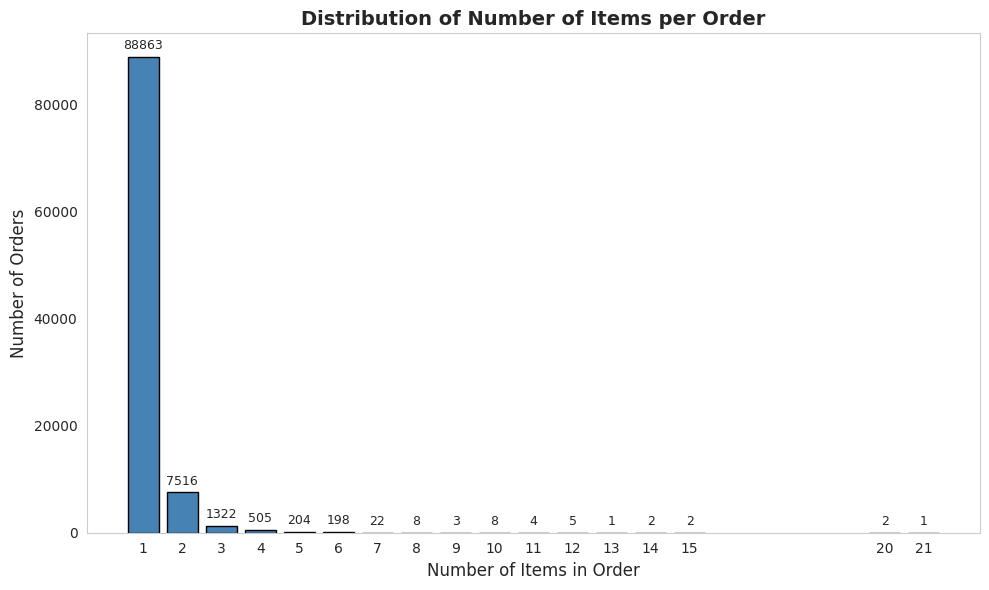

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume df_final contains order details, each row is an item, and includes order_id field

# Aggregate by order ID, count number of items per order
order_item_counts = df_final.groupby('order_id').size().reset_index(name='item_count')

# View distribution of item counts per order
item_count_distribution = order_item_counts['item_count'].value_counts().sort_index()

print(item_count_distribution)

# Plot - bar chart showing item count distribution
plt.figure(figsize=(10, 6))
bars = plt.bar(item_count_distribution.index, item_count_distribution.values, color='steelblue', edgecolor='black')

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + max(item_count_distribution.values)*0.01,
             f'{int(height)}', ha='center', va='bottom', fontsize=9)

plt.title('Distribution of Number of Items per Order', fontsize=14, fontweight='bold')
plt.xlabel('Number of Items in Order', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.xticks(item_count_distribution.index)
plt.grid(False)
plt.tight_layout()
plt.show()


##### **(4) Monthly Distribution of Customer Orders**  
**Data from Sep-Dec 2017 and Sep 2018 is incomplete (only early month data). For consistent analysis, use data from Jan 2018 to Aug 2019 only.**

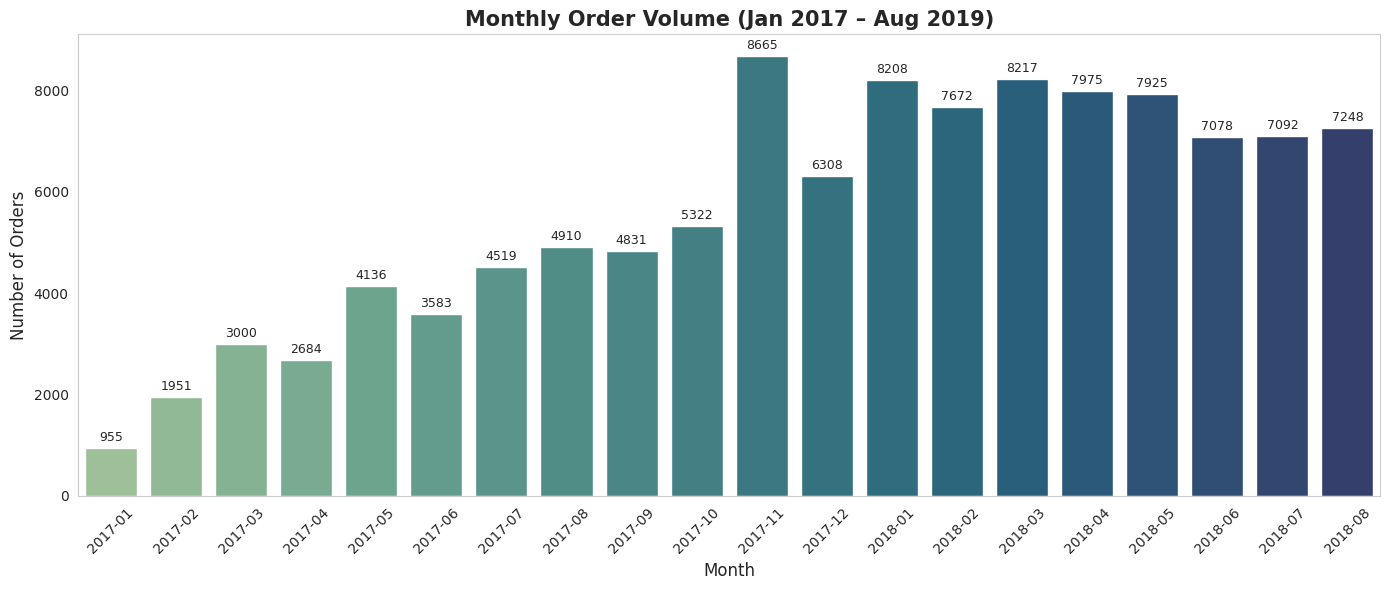

2018-08-29 15:00:37
['2017-09' '2017-04' '2018-01' '2018-08' '2017-02' '2017-05' '2017-12'
 '2018-07' '2018-03' '2018-02' '2018-04' '2018-05' '2017-08' '2017-11'
 '2017-03' '2018-06' '2017-10' '2017-01' '2017-06' '2017-07']


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Ensure time field format is correct
df_final['order_purchase_timestamp'] = pd.to_datetime(df_final['order_purchase_timestamp'])
# Filter time range: Jan 2017 to Aug 2019
df_filtered = df_final[
    (df_final['order_purchase_timestamp'] >= '2017-01-01') &
    (df_final['order_purchase_timestamp'] < '2018-09-01')  # Note: changed to 2018-09-01
].copy()  # Add .copy() to avoid chained assignment issue
df_filtered['order_month'] = df_filtered['order_purchase_timestamp'].dt.to_period('M').astype(str)
# Extract year and month info
df_filtered['order_month'] = df_filtered['order_purchase_timestamp'].dt.to_period('M').astype(str)
# Count orders by month
monthly_orders = df_filtered.groupby('order_month')['order_id'].count().reset_index()
monthly_orders.columns = ['Month', 'Order Count']
# Plot
plt.figure(figsize=(14, 6))
bars = sns.barplot(data=monthly_orders, x='Month', y='Order Count', palette='crest')  
# Add value labels on top
for bar in bars.patches:
    height = bar.get_height()
    bars.annotate(f'{int(height)}',
                  xy=(bar.get_x() + bar.get_width() / 2, height),
                  xytext=(0, 5),
                  textcoords='offset points',
                  ha='center', fontsize=9)
# Beautify chart
plt.title("Monthly Order Volume (Jan 2017 – Aug 2019)", fontsize=15, fontweight='bold')
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of Orders", fontsize=12)
plt.xticks(rotation=45)
plt.grid(False)  # Remove grid lines
plt.tight_layout()
plt.show()
print(df_filtered['order_purchase_timestamp'].max())
print(df_filtered['order_month'].unique())


#### **3. Customer Order Time Preferences**  
##### **Analyze order preferences by hour and weekday**

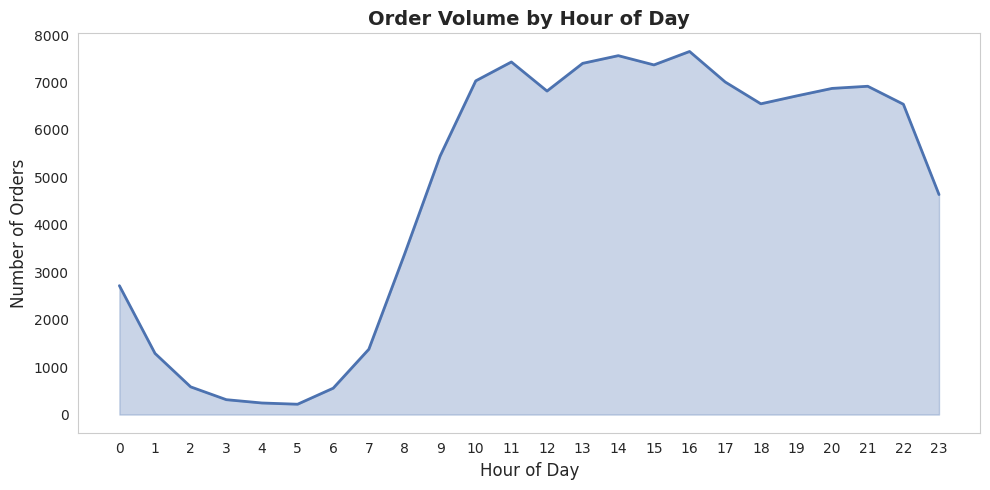

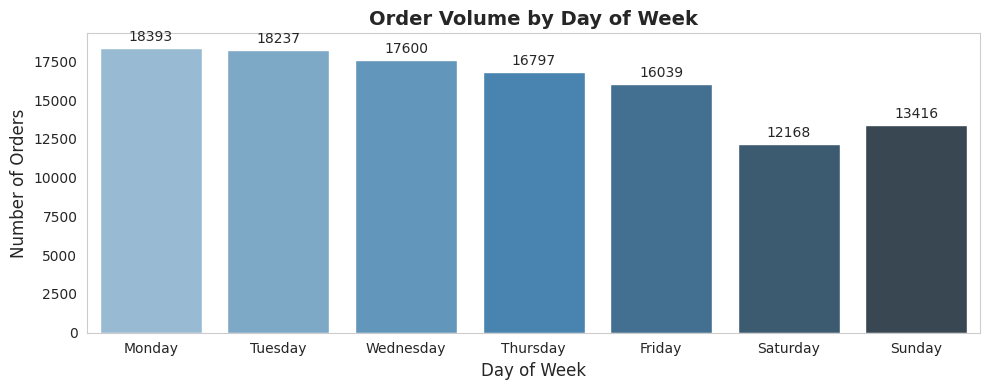

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Extract hour field
df_final['order_purchase_timestamp'] = pd.to_datetime(df_final['order_purchase_timestamp'])
df_final['order_hour'] = df_final['order_purchase_timestamp'].dt.hour

# 2. Count orders per hour
hourly_orders = df_final.groupby('order_hour')['order_id'].count()

# 3. Plot: line chart + area fill
plt.figure(figsize=(10, 5))
sns.lineplot(x=hourly_orders.index, y=hourly_orders.values, color='#4C72B0', linewidth=2)
plt.fill_between(hourly_orders.index, hourly_orders.values, color='#4C72B0', alpha=0.3)

plt.title("Order Volume by Hour of Day", fontsize=14, fontweight='bold')
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Number of Orders", fontsize=12)
plt.xticks(range(0, 24))
plt.grid(False)  # Remove grid lines
plt.tight_layout()
plt.show()

# 1. Extract weekday field (0=Monday)
df_final['order_weekday'] = df_final['order_purchase_timestamp'].dt.dayofweek

# 2. Count orders per weekday
weekday_orders = df_final.groupby('order_weekday')['order_id'].count()
weekday_map = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
weekday_orders.index = weekday_orders.index.map(weekday_map)

# 3. Plot: bar chart + value labels on top
plt.figure(figsize=(10, 4))
bars = sns.barplot(x=weekday_orders.index, y=weekday_orders.values, palette='Blues_d')

# Add value labels on top
for bar in bars.patches:
    height = bar.get_height()
    bars.annotate(f'{int(height)}',
                  xy=(bar.get_x() + bar.get_width() / 2, height),
                  xytext=(0, 5),
                  textcoords='offset points',
                  ha='center', fontsize=10)

plt.title("Order Volume by Day of Week", fontsize=14, fontweight='bold')
plt.xlabel("Day of Week", fontsize=12)
plt.ylabel("Number of Orders", fontsize=12)
plt.grid(False)  # Remove grid lines
plt.tight_layout()
plt.show()


### **2. Customer Satisfaction**

#### **1. Review Score**

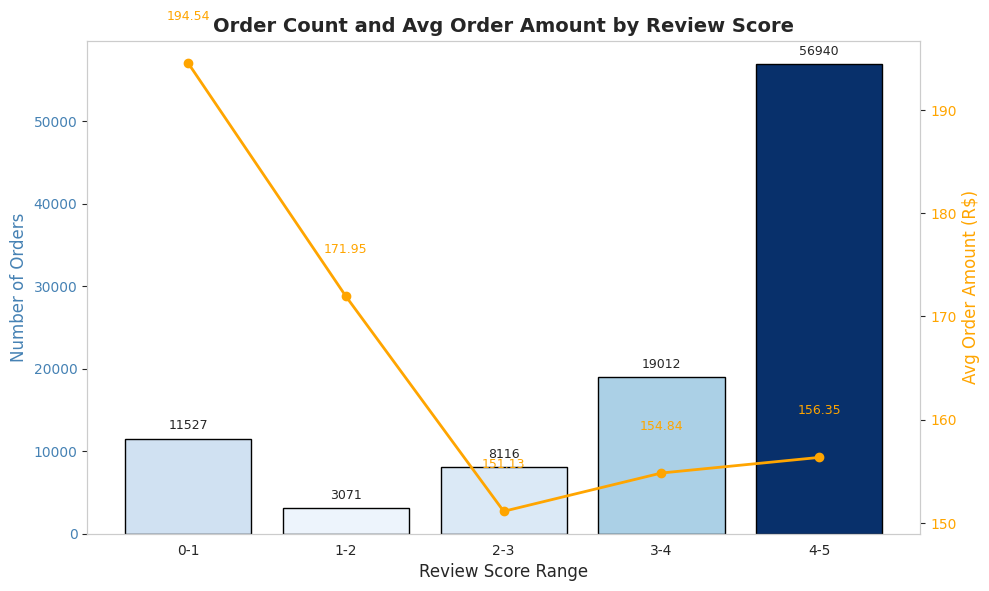

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Ensure fields are numeric type
df_final['price'] = pd.to_numeric(df_final['price'], errors='coerce')
df_final['freight_value'] = pd.to_numeric(df_final['freight_value'], errors='coerce')
df_final['review_score'] = pd.to_numeric(df_final['review_score'], errors='coerce')

# 2. Aggregate order total amount by order_id and review_score
df_total = df_final.groupby(['order_id', 'review_score'], as_index=False).agg({
    'price': 'sum',
    'freight_value': 'sum'
})
df_total['total_amount'] = df_total['price'] + df_total['freight_value']

# 3. Bin by score range (including 5, right-closed interval)
bins = [0, 1, 2, 3, 4, 5]
labels = ['0-1', '1-2', '2-3', '3-4', '4-5']
df_total['score_range'] = pd.cut(df_total['review_score'], bins=bins, labels=labels, right=True, include_lowest=True)

# 4. Count number of orders and average order amount for each score range
summary = df_total.groupby('score_range').agg({
    'order_id': 'count',
    'total_amount': 'mean'
}).rename(columns={'order_id': 'order_count', 'total_amount': 'avg_order_amount'}).round(2)

# 5. Visualization: bar chart + line chart
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart color gradient (from light blue to dark blue)
normed_counts = summary['order_count'] / summary['order_count'].max()
bar_colors = plt.cm.Blues(normed_counts)
bars = ax1.bar(summary.index, summary['order_count'], color=bar_colors, edgecolor='black')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height + max(summary['order_count'])*0.02,
             f'{int(height)}', ha='center', fontsize=9)

ax1.set_xlabel('Review Score Range', fontsize=12)
ax1.set_ylabel('Number of Orders', fontsize=12, color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')

# Line chart (average order amount)
ax2 = ax1.twinx()
ax2.plot(summary.index, summary['avg_order_amount'], color='orange', marker='o', linewidth=2)
ax2.set_ylabel('Avg Order Amount (R$)', fontsize=12, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add value labels on top of line chart
for i, v in enumerate(summary['avg_order_amount']):
    ax2.text(i, v + max(summary['avg_order_amount'])*0.02, f'{v:.2f}', ha='center', va='bottom', fontsize=9, color='orange')

# Title and turn off grid
plt.title('Order Count and Avg Order Amount by Review Score', fontsize=14, fontweight='bold')
ax1.grid(False)
ax2.grid(False)

plt.tight_layout()
plt.show()


**Although review_score is not a native dimension of the RFM model in customer segmentation, as a direct feedback indicator of "customer satisfaction", it has strong auxiliary analysis value.**

Although review_score is not a native dimension of the RFM model in customer segmentation, as a direct feedback indicator of "customer satisfaction", it has strong auxiliary analysis value. **It can be used as a supplementary dimension for user loyalty and satisfaction**
| Score Range    | User Characteristics         | Main Issues           | Development Strategy                                                                                         | Target                   |
| ----------- | ---------------- | ------------------ | ------------------------------------------------------------------------------------------------ | ---------------------- |
| **0-1**     | Extremely dissatisfied users, very poor experience | Very high risk of churn, possible complaints and negative reviews | - Immediate customer care, follow-up by phone/email<br>- Focus on collecting reasons for complaints, quick resolution<br>- Provide compensation or coupons to stimulate retention              | Reduce churn rate, repair brand image |
| **1-2**     | Clearly dissatisfied, serious problems | Poor service experience, low repurchase intention  | - Analyze main reasons for negative reviews (logistics, product quality, service, etc.)<br>- Optimize key links<br>- Targeted marketing, precise compensation and discounts               | Improve experience, promote repurchase       |
| **2-3**     | Generally satisfied, still room for improvement | Unstable experience, possible churn   | - Enhance customer interaction (surveys, exclusive activities)<br>- Personalized recommendations, improve purchase experience<br>- Increase customer education and guidance                | Increase satisfaction, promote stickiness     |
| **3-4**     | Quite satisfied, high loyalty | May become loyal customers, but still room for improvement | - Maintain existing relationships, regular follow-up<br>- VIP programs and member benefits<br>- Incentivize sharing and word-of-mouth                             | Increase customer lifetime value (LTV)  |
| **4-5**     | Very satisfied, loyal customers   | Positive word-of-mouth, high repurchase rate | - Focus on cultivating brand advocates<br>- Introduce referral reward programs<br>- Provide exclusive new product experiences and early purchase rights                          | Expand customer base, promote word-of-mouth fission |


#### **2. Analysis of Reasons for Review Score Differences**

##### **(1) Order Dimension**

From the perspective of product quality, compare the product categories corresponding to orders in different review score ranges.

In [ ]:
# Divide review score ranges
bins = [0, 1, 2, 3, 4, 5]
labels = ['0-1', '1-2', '2-3', '3-4', '4-5']
df_final['score_group'] = pd.cut(df_final['review_score'], bins=bins, labels=labels, right=True, include_lowest=True)

# Count unique order numbers by review score range and product category

score_group,0-1 Count,1-2 Count,2-3 Count,3-4 Count,4-5 Count,0-1 %,1-2 %,2-3 %,3-4 %,4-5 %
product_category_name_english,,,,,,,,,,
agro_industry_and_commerce,21,6,13,50,92,11.54%,3.30%,7.14%,27.47%,50.55%
air_conditioning,38,7,19,47,142,15.02%,2.77%,7.51%,18.58%,56.13%
art,27,7,18,38,112,13.37%,3.47%,8.91%,18.81%,55.45%
arts_and_craftmanship,3,0,2,3,15,13.04%,0.00%,8.70%,13.04%,65.22%
audio,60,19,33,53,185,17.14%,5.43%,9.43%,15.14%,52.86%
auto,454,125,305,804,2209,11.65%,3.21%,7.83%,20.63%,56.68%
baby,384,98,245,525,1633,13.31%,3.40%,8.49%,18.20%,56.60%
bed_bath_table,1276,377,949,1850,4965,13.55%,4.00%,10.08%,19.65%,52.72%
books_general_interest,40,6,17,77,372,7.81%,1.17%,3.32%,15.04%,72.66%


Since the number of orders for each product category is different, to improve product quality more effectively, you should first focus on categories with more orders or review scores. Analyze the review score distribution and characteristics of these categories, and develop improvement strategies to achieve the best results.

In [ ]:
# 计算商品类别的总评分订单数
total_orders_by_category = pivot_counts.sum(axis=1).reset_index().rename(columns={0: 'total_orders'})

# 按总评分订单数降序排列，选出前20名
top_20_categories = total_orders_by_category.sort_values(by='total_orders', ascending=False).head(20)

# 从原始的pivot_percent表中选出前20商品类别的百分比
top_20_percent = pivot_percents.loc[top_20_categories['product_category_name_english']]

# 美化输出的百分比表格
top_20_percent_styled = top_20_percent.style \
    .background_gradient(cmap='Purples', axis=1) \
    .format("{:.2f}%", subset=top_20_percent.columns) \
    .set_caption("Top 20 Product Categories: Review Score Percentages") \
    .set_table_styles([
        {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-weight', 'bold'), ('font-size', '16px')]},
        {'selector': 'th', 'props': [('background-color', '#f0f0f0'), ('font-weight', 'bold')]}
    ])

top_20_percent_styled


score_group,0-1,1-2,2-3,3-4,4-5
product_category_name_english,,,,,
bed_bath_table,13.55%,4.00%,10.08%,19.65%,52.72%
health_beauty,10.85%,2.44%,7.75%,17.94%,61.01%
sports_leisure,11.09%,2.49%,7.20%,19.07%,60.16%
computers_accessories,13.11%,3.39%,8.21%,20.05%,55.24%
furniture_decor,13.38%,3.91%,8.81%,18.47%,55.43%
housewares,10.66%,3.09%,8.53%,18.97%,58.75%
watches_gifts,12.50%,3.41%,8.52%,18.78%,56.79%
telephony,12.31%,3.79%,9.93%,21.43%,52.54%
auto,11.65%,3.21%,7.83%,20.63%,56.68%


**Delivery timeliness issues**

In [ ]:
# First, select the top 20 English product categories ranked by total number of rated orders.
pivot_table_eng = pd.pivot_table(df_final, 
                                index='product_category_name_english', 
                                columns='review_score', 
                                values='order_id', 
                                aggfunc='count', 
                                fill_value=0)

top20_products_eng = pivot_table_eng.sum(axis=1).sort_values(ascending=False).head(20).index.tolist()

# Keep only the data for the top 20 English product categories
df_top20_eng = df_final[df_final['product_category_name_english'].isin(top20_products_eng)].copy()

# Convert time format and calculate delivery delay.
df_top20_eng['order_delivered_customer_date'] = pd.to_datetime(df_top20_eng['order_delivered_customer_date'], errors='coerce')
df_top20_eng['order_estimated_delivery_date'] = pd.to_datetime(df_top20_eng['order_estimated_delivery_date'], errors='coerce')
df_top20_eng['delivery_delay'] = (df_top20_eng['order_delivered_customer_date'] - df_top20_eng['order_estimated_delivery_date']).dt.days

# Score segmentation, including zero scores.
bins = [0, 1, 2, 3, 4, 5]
labels = ['[0-1]', '(1-2]', '(2-3]', '(3-4]', '(4-5]']
df_top20_eng['review_score_bin'] = pd.cut(df_top20_eng['review_score'], 
                                          bins=bins, 
                                          labels=labels, 
                                          include_lowest=True,
                                          right=True)

# Calculate the average delivery delay by product category and score segment.
delay_table_eng = df_top20_eng.groupby(['product_category_name_english', 'review_score_bin'])['delivery_delay'] \
                              .mean().unstack().reindex(index=top20_products_eng, columns=labels).round(2)

# Table with color gradient
styled_delay_table_eng = delay_table_eng.style \
    .background_gradient(cmap='coolwarm_r', axis=None) \
    .set_caption("Average Delivery Delay by Top 20 Product Categories and Review Score (English)") \
    .format("{:.2f}") \
    .set_table_styles([
        {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-weight', 'bold'), ('font-size', '16px')]}
    ])

styled_delay_table_eng


review_score_bin,[0-1],(1-2],(2-3],(3-4],(4-5]
product_category_name_english,,,,,
bed_bath_table,-6.96,-10.49,-11.16,-12.08,-13.02
health_beauty,-3.74,-7.23,-11.03,-12.60,-13.52
sports_leisure,-4.66,-10.19,-11.26,-12.45,-13.38
furniture_decor,-7.65,-11.71,-11.96,-12.84,-13.66
computers_accessories,-7.18,-10.25,-11.00,-13.30,-13.79
housewares,-7.98,-11.56,-11.56,-12.21,-13.31
watches_gifts,-5.83,-9.09,-10.80,-12.23,-13.46
telephony,-5.57,-9.22,-9.99,-11.68,-13.05
garden_tools,-5.40,-8.48,-12.11,-13.05,-13.20


Seller analysis: Analyze the top 10 sellers by order count, and summarize their product types and review score distribution.

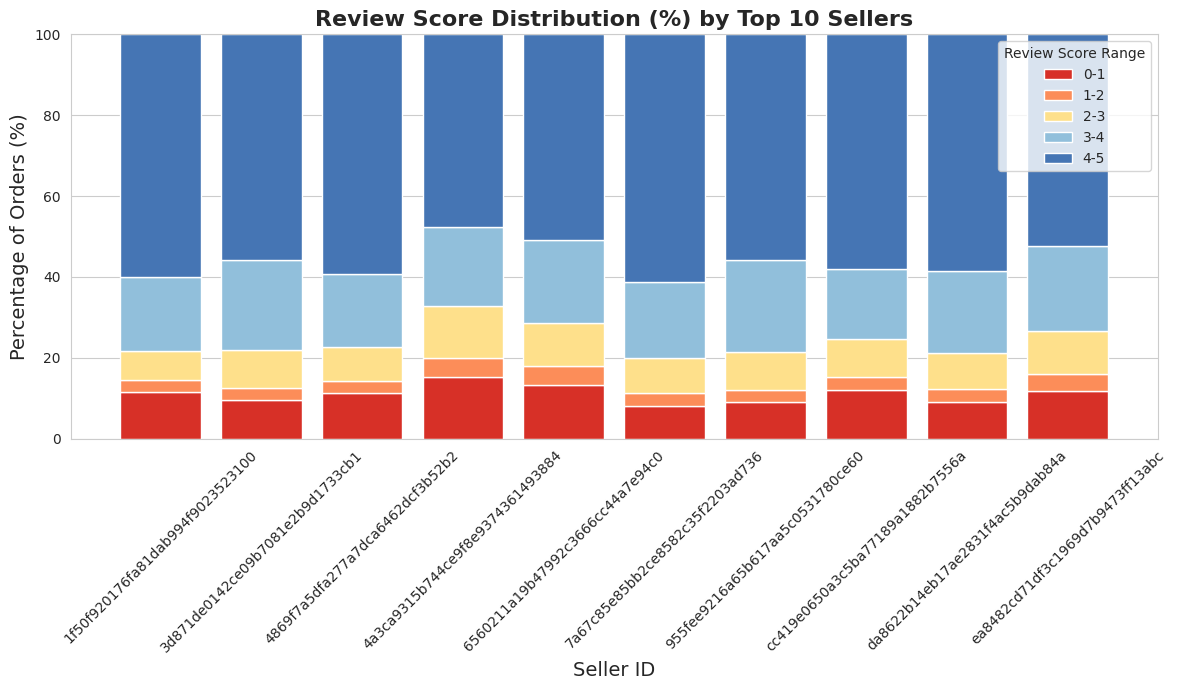

Top 10 Seller IDs on x-axis:
['1f50f920176fa81dab994f9023523100', '3d871de0142ce09b7081e2b9d1733cb1', '4869f7a5dfa277a7dca6462dcf3b52b2', '4a3ca9315b744ce9f8e9374361493884', '6560211a19b47992c3666cc44a7e94c0', '7a67c85e85bb2ce8582c35f2203ad736', '955fee9216a65b617aa5c0531780ce60', 'cc419e0650a3c5ba77189a1882b7556a', 'da8622b14eb17ae2831f4ac5b9dab84a', 'ea8482cd71df3c1969d7b9473ff13abc']


In [ ]:
# 1. Count the number of unique orders for each seller.
seller_order_counts = df_final.groupby('seller_id')['order_id'].nunique()
# 2. Select the seller IDs of the top 10 sellers by order count.
top10_sellers = seller_order_counts.sort_values(ascending=False).head(10).index.tolist()
# 3. Filter to keep only order data for these 10 sellers.
df_top10 = df_final[df_final['seller_id'].isin(top10_sellers)].copy()
# 4. Count unique orders by seller and rating.
# Note: Orders may contain multiple products, resulting in duplicate order IDs; use nunique to ensure orders are counted uniquely.
seller_score_counts = df_top10.groupby(['seller_id', 'review_score'])['order_id'].nunique().reset_index()
# 5. Convert scores into categorical intervals (0-1, 1-2, 2-3, 3-4, 4-5).
bins = [0, 1, 2, 3, 4, 5]
labels = ['0-1', '1-2', '2-3', '3-4', '4-5']
seller_score_counts['score_range'] = pd.cut(seller_score_counts['review_score'], bins=bins, labels=labels, right=True, include_lowest=True)
# 6. Aggregate order counts by seller and score interval
seller_score_range = seller_score_counts.groupby(['seller_id', 'score_range'])['order_id'].sum().reset_index()
# 7. Create a pivot table with sellers as rows, score intervals as columns, and order counts as values.
pivot_scores = seller_score_range.pivot(index='seller_id', columns='score_range', values='order_id').fillna(0)
# 8. Calculate the total number of orders for each seller and normalize them as percentages.
pivot_scores_pct = pivot_scores.div(pivot_scores.sum(axis=1), axis=0) * 100

plt.figure(figsize=(12, 7))
bottom = pd.Series([0]*len(pivot_scores_pct), index=pivot_scores_pct.index)  # Initialize the starting point of the cumulative sum at 0.
colors = ['#d73027', '#fc8d59', '#fee08b', '#91bfdb', '#4575b4']  # Color adjustable, ranging from red to blue.
for i, score_range in enumerate(pivot_scores_pct.columns):
    plt.bar(
        pivot_scores_pct.index,
        pivot_scores_pct[score_range],
        bottom=bottom,
        color=colors[i],
        label=score_range
    )
    bottom += pivot_scores_pct[score_range]
plt.legend(title='Review Score Range')
plt.title('Review Score Distribution (%) by Top 10 Sellers', fontsize=16, fontweight='bold')
plt.xlabel('Seller ID', fontsize=14)
plt.ylabel('Percentage of Orders (%)', fontsize=14)
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()
print("Top 10 Seller IDs on x-axis:")
print(pivot_scores_pct.index.tolist())


It is not difficult to see that the fourth seller '4a3ca9315b744ce9f8e9374361493884' has a high proportion of low review scores and few high scores (above 4). This seller has issues and should be closely monitored and studied. Find out what product categories they sell, and compare their review score distribution with other sellers selling the same categories.

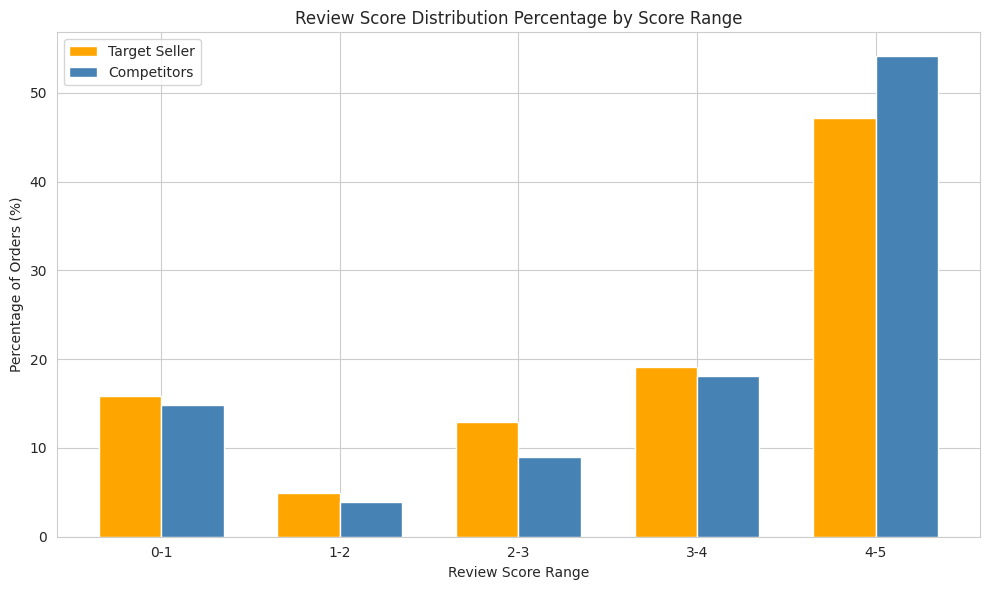

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# "Set score intervals and labels, including a score of 0.
bins = [0, 1, 2, 3, 4, 5]
labels = ['0-1', '1-2', '2-3', '3-4', '4-5']

target_seller = '4a3ca9315b744ce9f8e9374361493884'

# Add a score interval column to df_final.
df_final['score_group'] = pd.cut(df_final['review_score'], bins=bins, labels=labels, right=True, include_lowest=True)

# Data of target sellers
df_seller = df_final[df_final['seller_id'] == target_seller]

# Count the number of orders for each score interval for the seller and convert them into proportions.
seller_score_counts = df_seller['score_group'].value_counts(normalize=True).reindex(labels, fill_value=0).sort_index() * 100

# Find the top 5 product categories sold by the seller.
top_categories = df_seller.groupby('product_category_name_english')['order_id'].nunique().sort_values(ascending=False).head(5).index.tolist()

# Competitor data (same product categories, but not the seller)
df_competitors = df_final[(df_final['product_category_name_english'].isin(top_categories)) & (df_final['seller_id'] != target_seller)]

# Competitor score interval statistics (order count proportions)
competitor_score_counts = df_competitors['score_group'].value_counts(normalize=True).reindex(labels, fill_value=0).sort_index() * 100

# Plot a comparison chart
bar_width = 0.35
index = np.arange(len(labels))

plt.figure(figsize=(10,6))
plt.bar(index, seller_score_counts, bar_width, label='Target Seller', color='orange')
plt.bar(index + bar_width, competitor_score_counts, bar_width, label='Competitors', color='steelblue')

plt.xlabel('Review Score Range')
plt.ylabel('Percentage of Orders (%)')
plt.title('Review Score Distribution Percentage by Score Range')
plt.xticks(index + bar_width / 2, labels)
plt.legend()
plt.tight_layout()
plt.show()


Obviously, this seller has a higher proportion of negative reviews compared to other sellers in the same product category, and a lower proportion of positive reviews (4-5 points) than peers.

### **3. LTV Analysis**

#### **1. New Users**
    Goal: Analyze customer acquisition, such as the number of new customers by time (month/week)

In [ ]:
# Convert to datetime type (if not already processed)）
df_final['order_purchase_timestamp'] = pd.to_datetime(df_final['order_purchase_timestamp'])

# Define the time period
start_date = pd.to_datetime('2017-01-01')
end_date = pd.to_datetime('2018-08-31')

# Filter orders within the specified time range.
df_final = df_final[(df_final['order_purchase_timestamp'] >= start_date) &
                    (df_final['order_purchase_timestamp'] <= end_date)]


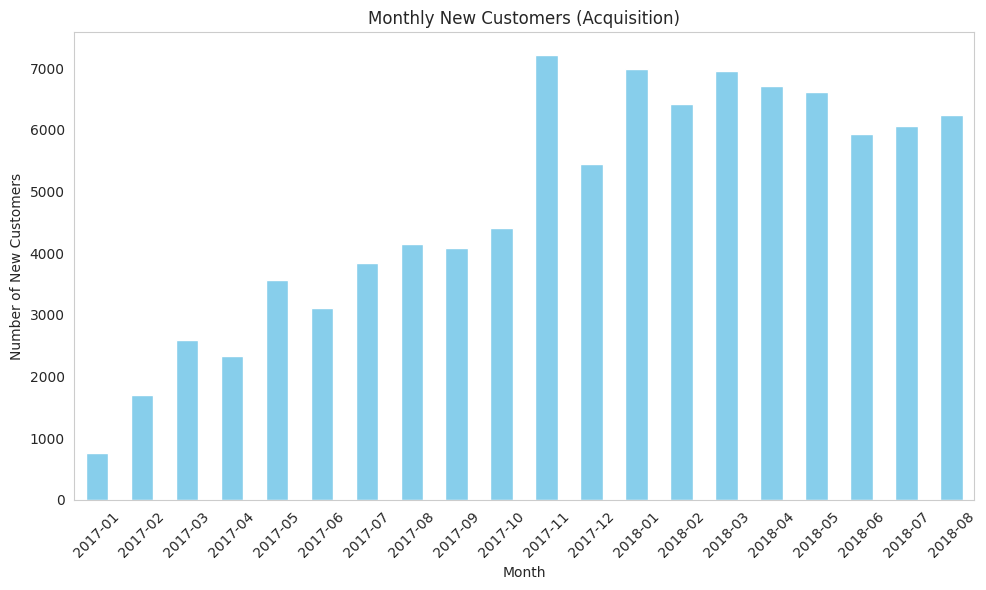

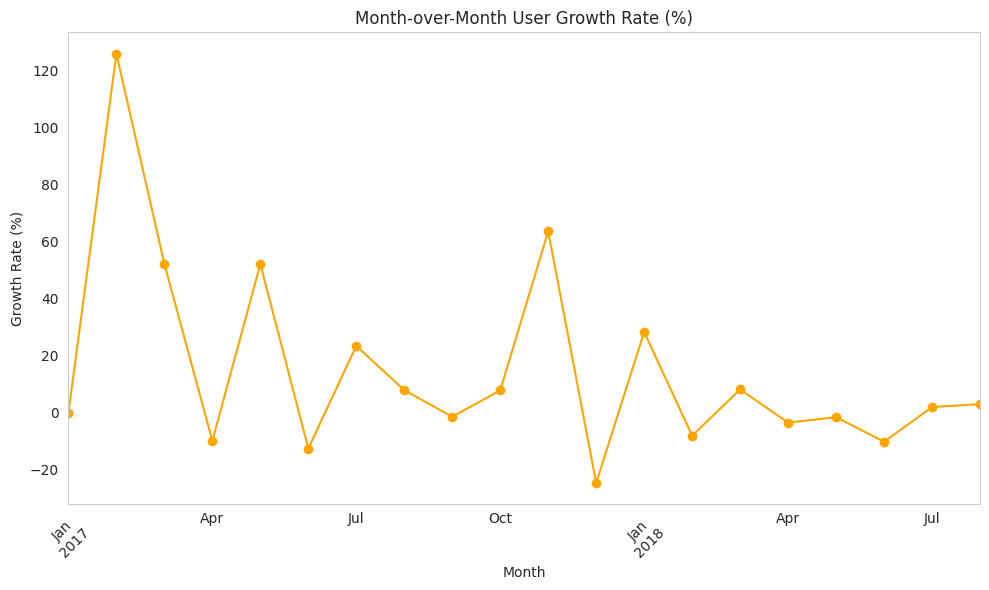

In [ ]:
import matplotlib.pyplot as plt

# 1. Calculate the first purchase month for each user.
first_order = df_final.groupby('customer_unique_id')['order_purchase_timestamp'].min().reset_index()
first_order['first_order_month'] = first_order['order_purchase_timestamp'].dt.to_period('M')

# 2. Calculate the number of new users added per month
monthly_new_customers = first_order.groupby('first_order_month')['customer_unique_id'].nunique()

# 3. Compute the user growth rate on a month-over-month basis, expressed as a percentage
user_growth_rate = monthly_new_customers.pct_change().fillna(0) * 100

# 4. Visualize new user growth with a bar chart
plt.figure(figsize=(10,6))
monthly_new_customers.plot(kind='bar', color='skyblue')
plt.title('Monthly New Customers (Acquisition)')
plt.xlabel('Month')
plt.ylabel('Number of New Customers')
plt.xticks(rotation=45)
plt.grid(False)  # 关闭网格线
plt.tight_layout()
plt.show()

# 5. Visualize the user growth rate with a line plot
plt.figure(figsize=(10,6))
user_growth_rate.plot(kind='line', marker='o', color='orange')
plt.title('Month-over-Month User Growth Rate (%)')
plt.xlabel('Month')
plt.ylabel('Growth Rate (%)')
plt.xticks(rotation=45)
plt.grid(False)  # Turn off gridlines
plt.tight_layout()
plt.show()



#### **2. User Activity (Activation)**
    Goal: Analyze user order behavior, including the distribution of order counts per user

In [ ]:
import pandas as pd

# Calculate the number of orders for each user (i.e., purchase frequency).
order_counts = df_final.groupby('customer_unique_id')['order_id'].nunique()

# Count the number of users for each order frequency
order_count_dist = order_counts.value_counts().sort_index().reset_index()
order_count_dist.columns = ['Order Count', 'User Count']

# Add a column showing the percentage of users (formatted as percentages)
total_users = order_count_dist['User Count'].sum()
order_count_dist['User Percent'] = order_count_dist['User Count'] / total_users

# Apply formatting to the table with Pandas Styler
styled_table = order_count_dist.style \
    .format({
        'User Count': '{:,}',
        'User Percent': '{:.2%}'
    }) \
    .bar(subset='User Percent', color='#FFB347') \
    .set_caption("User Activation Distribution Table") \
    .set_properties(**{
        'text-align': 'center',
        'font-size': '12px'
    }) \
    .hide(axis='index')  # Hide row index

styled_table



Order Count,User Count,User Percent
1,"92,221",96.95%
2,"2,661",2.80%
3,191,0.20%
4,29,0.03%
5,9,0.01%
6,5,0.01%
7,3,0.00%
9,1,0.00%
16,1,0.00%


#### **3. User Retention**
    Goal: Analyze user repurchase rate and whether users continue to buy

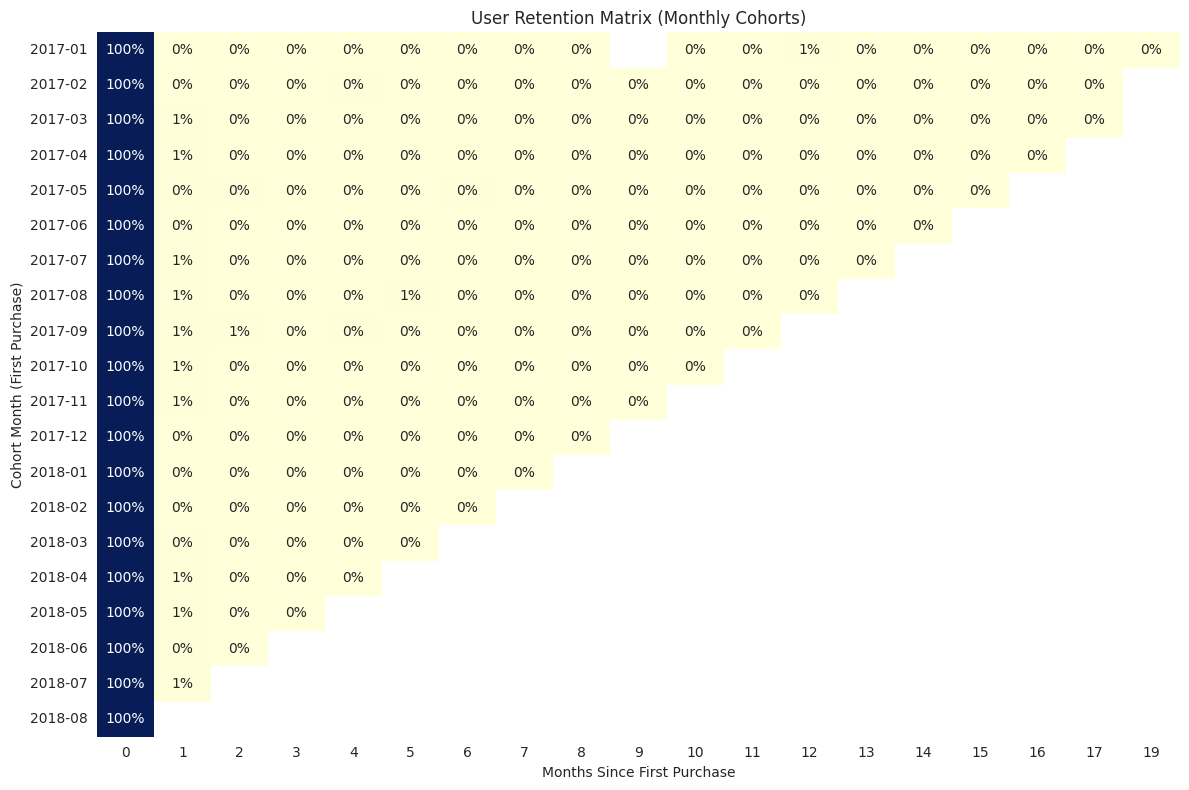

In [ ]:
import seaborn as sns

# First purchase month for each user
user_first_month = first_order.set_index('customer_unique_id')['first_order_month']

# Order mont
df_final['order_month'] = df_final['order_purchase_timestamp'].dt.to_period('M')

# Create a function to generate a retention matrix
def get_retention_matrix(df, user_first_month):
    df = df[['customer_unique_id', 'order_month']].drop_duplicates()
    df['cohort_index'] = (df['order_month'] - df['customer_unique_id'].map(user_first_month)).apply(lambda x: x.n)
    df['cohort'] = df['customer_unique_id'].map(user_first_month)
    cohort_data = df.groupby(['cohort', 'cohort_index'])['customer_unique_id'].nunique().reset_index()
    cohort_pivot = cohort_data.pivot(index='cohort', columns='cohort_index', values='customer_unique_id')
    cohort_size = cohort_pivot.iloc[:,0]
    retention = cohort_pivot.divide(cohort_size, axis=0)
    return retention

# Calculate the retention matrix
retention = get_retention_matrix(df_final, user_first_month)

# Plot a retention heatmap
plt.figure(figsize=(12,8))
sns.heatmap(retention, annot=True, fmt=".0%", cmap="YlGnBu", cbar=False)
plt.title("User Retention Matrix (Monthly Cohorts)")
plt.ylabel("Cohort Month (First Purchase)")
plt.xlabel("Months Since First Purchase")
plt.grid(False)
plt.tight_layout()
plt.show()


#### **4. Revenue**
    Goal: User LTV distribution and average revenue

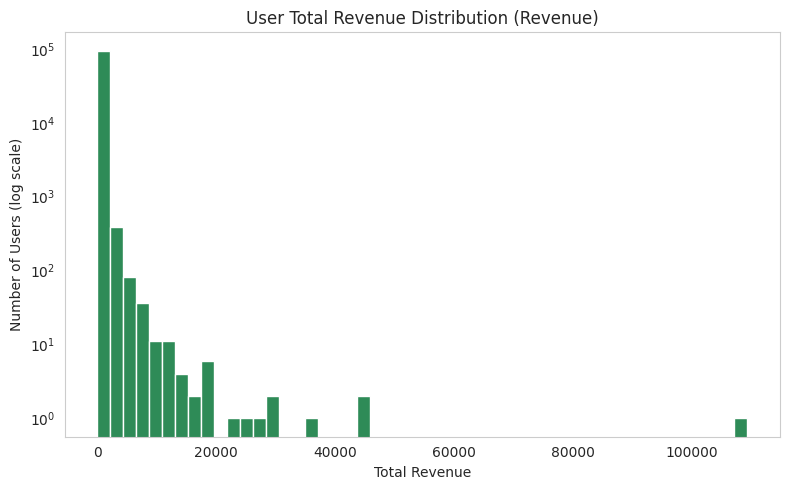

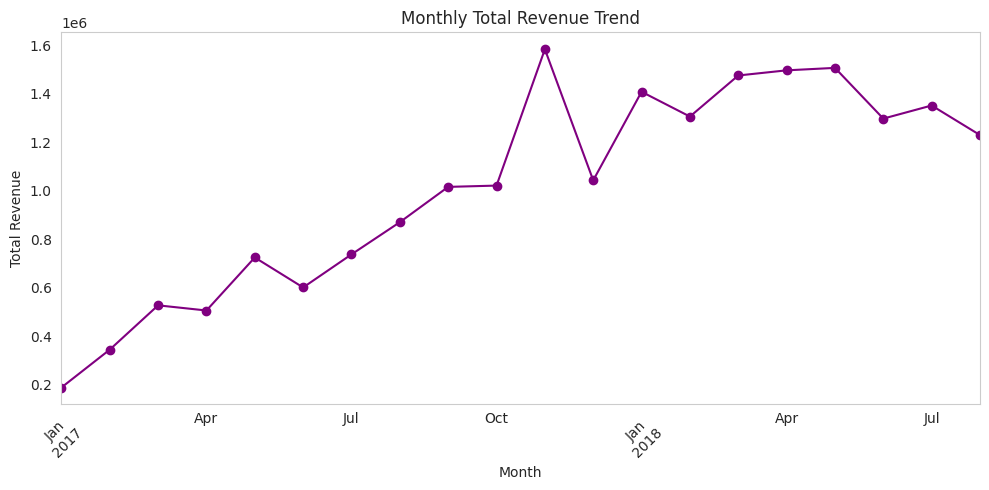

In [ ]:
# Calculate the total spending amount for each user.
revenue_user = df_final.groupby('customer_unique_id')['payment_total'].sum()

# Histogram of user spending distribution (log scale)）
plt.figure(figsize=(8,5))
plt.hist(revenue_user, bins=50, color='seagreen', log=True)
plt.title('User Total Revenue Distribution (Revenue)')
plt.xlabel('Total Revenue')
plt.ylabel('Number of Users (log scale)')
plt.grid(False)
plt.tight_layout()
plt.show()

# Calculate total revenue by month
monthly_revenue = df_final.groupby('order_month')['payment_total'].sum()

# Plot a line chart of monthly revenue trends
plt.figure(figsize=(10,5))
monthly_revenue.plot(kind='line', marker='o', color='purple')
plt.title('Monthly Total Revenue Trend')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Step 1: Total payment amount for each user = LTV
user_ltv = df_final.groupby('customer_unique_id', as_index=False)['payment_total'].sum()
user_ltv.columns = ['customer_unique_id', 'ltv']

# Step 2: Segmenting users by LTV (Customer Lifetime Value)
bins = [0, 100, 300, 600, 1000, 1500, 3000, user_ltv['ltv'].max() + 1]
labels = ['0-100', '100-300', '300-600', '600-1000', '1000-1500', '1500-3000', '3000+']
user_ltv['ltv_segment'] = pd.cut(user_ltv['ltv'], bins=bins, labels=labels, right=False)

# Step 3: Count the number of users, average revenue, and total revenue for each segment.
ltv_summary = user_ltv.groupby('ltv_segment', observed=True).agg(
    User_Count=('customer_unique_id', 'count'),
    Avg_LTV=('ltv', 'mean'),
    Total_LTV=('ltv', 'sum')
).reset_index()

# Step 4: Format the table for better presentation
styled_ltv_table = (
    ltv_summary.style
    .format({
        'User_Count': '{:,}',
        'Avg_LTV': '¥{:.2f}',
        'Total_LTV': '¥{:.2f}'
    })
    .bar(subset=['User_Count'], color='#FF9999')
    .set_caption("User Segmentation by LTV")
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#f0f0f0'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center')]},
    ])
)

styled_ltv_table


,ltv_segment,User_Count,Avg_LTV,Total_LTV
0,0-100,"42,354",¥59.92,¥2537713.91
1,100-300,"38,401",¥167.49,¥6431644.70
2,300-600,"8,794",¥408.12,¥3589025.02
3,600-1000,"3,193",¥754.96,¥2410572.82
4,1000-1500,"1,201",¥1205.97,¥1448373.12
5,1500-3000,845,¥1999.65,¥1689707.12
6,3000+,333,¥6386.34,¥2126649.84


In [ ]:
overall_avg_ltv = user_ltv['ltv'].mean()
overall_row = pd.DataFrame({
    'ltv_segment': ['Overall Avg'],
    'User_Count': [user_ltv.shape[0]],
    'Avg_LTV': [overall_avg_ltv],
    'Total_LTV': [user_ltv['ltv'].sum()]
})

ltv_summary_with_avg = pd.concat([ltv_summary, overall_row], ignore_index=True)
def highlight_ltv(val):
    color = 'lightcoral' if val > overall_avg_ltv else 'lightgreen'
    return f'background-color: {color}'


styled_ltv_table = (
    ltv_summary_with_avg.style
    .format({
        'User_Count': '{:,}',
        'Avg_LTV': '¥{:.2f}',
        'Total_LTV': '¥{:.2f}'
    })
    .bar(subset=['User_Count'], color='#FF9999')
    .applymap(highlight_ltv, subset=['Avg_LTV'])
    .set_caption("User Segmentation by LTV (With Overall Average)")
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#f0f0f0'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center')]},
    ])
)
styled_ltv_table

,ltv_segment,User_Count,Avg_LTV,Total_LTV
0,0-100,"42,354",¥59.92,¥2537713.91
1,100-300,"38,401",¥167.49,¥6431644.70
2,300-600,"8,794",¥408.12,¥3589025.02
3,600-1000,"3,193",¥754.96,¥2410572.82
4,1000-1500,"1,201",¥1205.97,¥1448373.12
5,1500-3000,845,¥1999.65,¥1689707.12
6,3000+,333,¥6386.34,¥2126649.84
7,Overall Avg,"95,121",¥212.72,¥20233686.53


#### **5. User Referral**
    Missing relevant data

###   **AARRR Five Dimensions Analysis and Strategic Recommendations**

#### 1. **Acquisition (User Acquisition)**

#### **Current Situation Analysis**：
- Users continuously increased from January to November 2017, but growth stagnated after November and new users remained stable.",
- This may indicate market saturation or a decline in the effectiveness of current acquisition strategies. The repurchase rate is low, so while trying to improve repurchase, attention should also be paid to acquiring new users to compare which approach is more effective for revenue.


#### **Strategic Recommendations**:
- **Diversified Channels & Targeted Marketing**: Expand user acquisition channels. In addition to existing channels, try social media, partner marketing, referrals, etc. to attract new users.",
"- **Optimize Advertising & Campaign Effectiveness**: Use data analysis to optimize ad placements and ensure marketing budgets are used efficiently. Design targeted campaigns for potential users to improve conversion.

#### 2. **Activation (User Activation)**

#### **Current Situation Analysis**:
- Most users place only one order, with only about 2% placing two orders. Repurchase rate is extremely low.
- There is a lack of effective incentives to encourage repeat purchases.

#### **Strategic Recommendations**:
- **First Purchase Incentives**: Offer coupons, discounts, etc. to first-time buyers to ensure an attractive initial experience.
- **Optimize First Experience**: Improve the simplicity and smoothness of the purchase process to prevent user loss due to complexity.
- **Personalized Recommendations**: Recommend related products or services based on browsing and purchase history to encourage a second purchase. Use precise recommendations to enhance motivation.

#### 3. **Retention (User Retention)**

#### **Current Situation Analysis**:
- Repurchase rate is extremely low. Most users repurchase in the next month, but few make purchases over a longer period.
- User stickiness is poor, lacking long-term incentives and interaction.


#### **Strategic Recommendations**:
- **Personalized Marketing & Custom Recommendations**: Use data analysis to recommend personalized products and services, making each user feel special.
- **Membership System**: Launch a membership program where users gain exclusive benefits, event invitations, etc. through points and level upgrades to increase stickiness.
- **Regular Follow-up & Feedback Mechanism**: Communicate regularly via email or SMS to understand user needs and issues, proactively provide after-sales service and product updates.

#### 4. **Revenue**

#### **Current Situation Analysis**:
- 90% of users spend less than 300 BRL, 10% spend between 300-600 BRL, and a few spend over 600 BRL.
- Most users have low LTV (lifetime value), and high-value users are few. High-value users have not been effectively identified.

#### **Strategic Recommendations**:
- **Identify High-Value Users**: Use data analysis to identify potential high-value users and offer them personalized recommendations and exclusive discounts to make them loyal customers.
- **Increase Average Order Value (AOV)**: Use bundling and cross-selling strategies to increase purchase amounts. For example, recommend high-value products or gifts when users buy low-value items.
- **Increase Exposure of High-Profit Products**: Increase inventory and display priority for high-priced, high-margin products so users can easily find and buy them.


#### 5. **Referral (User Referral)**

#### **Current Situation Analysis**:
- There is currently a lack of effective referral reward mechanisms, and users rarely engage in social sharing or inviting others.

#### **Strategic Recommendations**:
- **Referral Reward Program**: Set up rewards (cashback, points, coupons, etc.) for users who refer new users to encourage referrals.
- **Social Media Engagement**: Encourage users to share their shopping experiences on social platforms for brand promotion. Use gifts or points to incentivize sharing.
- **User Community Building**: Create a community or forum for users to share product experiences and usage tips, increasing interaction and brand loyalty.
    

---
#### **Comprehensive Strategy:**

1. **From the perspective of user acquisition:**
       - **Optimize acquisition channels** to increase brand exposure and conversion rates.
       - Offer **first order discounts** and **personalized recommendations** to ensure new users have a pleasant first purchase experience and increase activation.

2. **Increase repurchase rate through effective incentives:**
       - Design **repurchase incentive mechanisms** to encourage users to return for a second purchase after their first. Use coupons, points, etc. to boost repurchase.

3. **Enhance user stickiness and retention:**
       - Launch a **membership system** to increase loyalty and long-term retention through points and levels.
       - Use data analysis to optimize **personalized recommendations** and improve user experience, reducing churn.


4. **Increase revenue contribution from high-value users:**
       - Analyze data to identify potential **high-value users** and market to them with customized offers to increase their average order value and repurchase rate.
    
5. **Encourage user referrals:**
       - Establish a **referral mechanism** so existing users help promote the platform, increasing the user base and retention.

---

####  **Summary:**
   - The current repurchase rate issue stems from weak **user activation** and **retention**, especially the lack of effective repurchase incentives.
   - By strengthening **user acquisition** and **first purchase incentives**, user activity and repurchase can be improved.
   - Enhancing **personalized recommendations** and **incentive mechanisms** will increase user stickiness and repurchase probability, thereby boosting overall revenue and long-term user value (LTV).
    
---



## **Analysis Using RFM and K-means Clustering**

#### **1. Recency**
    Time interval between current date and user's most recent purchase date

                 customer_unique_id  recency
0  0000366f3b9a7992bf8c76cfdf3221e2      112
1  0000b849f77a49e4a4ce2b2a4ca5be3f      115
2  0000f46a3911fa3c0805444483337064      537
3  0000f6ccb0745a6a4b88665a16c9f078      321
4  0004aac84e0df4da2b147fca70cf8255      288


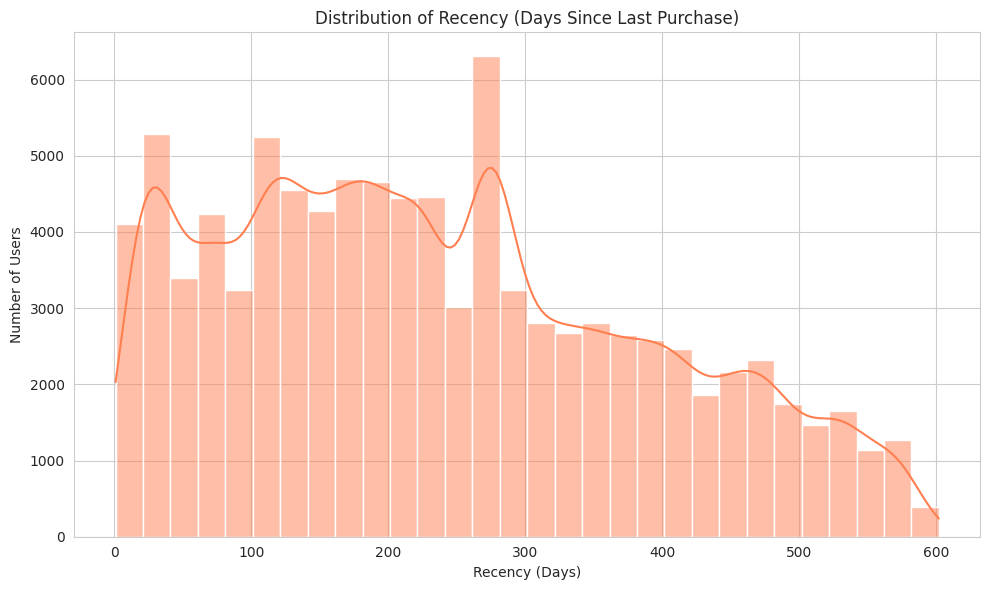


Descriptive Statistics for Recency:
count    95121.000000
mean       237.539345
std        151.271159
min          1.000000
25%        115.000000
50%        219.000000
75%        346.000000
max        602.000000
Name: recency, dtype: float64


In [ ]:
import pandas as pd
from datetime import datetime
current_date = df_final['order_purchase_timestamp'].max() + pd.Timedelta(days=1)
recency = df_final.groupby('customer_unique_id').agg(
    recency=('order_purchase_timestamp', lambda x: (current_date - x.max()).days)
).reset_index()
print(recency.head())
recency_desc = recency['recency'].describe()
recency_desc_df = recency_desc.to_frame().T  # Convert to a DataFrame and transpose it.
styled_table = recency_desc_df.style.format("{:,.2f}") \
    .background_gradient(cmap="coolwarm") \
    .set_caption("Descriptive Statistics for Recency") \
    .set_table_styles([{
        'selector': 'caption', 
        'props': [('font-size', '16px'), ('font-weight', 'bold')]
    }, {
        'selector': 'th',  # Clean up column headers
        'props': [('background-color', '#f0f0f0'), ('color', 'black'), ('font-weight', 'bold')]
    }, {
        'selector': 'td',  # Format the table content for better presentation
        'props': [('text-align', 'center'), ('padding', '10px')]
    }])
styled_table
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(recency['recency'], kde=True, color='coral', bins=30)
plt.title('Distribution of Recency (Days Since Last Purchase)')
plt.xlabel('Recency (Days)')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()
print("\nDescriptive Statistics for Recency:")
print(recency_desc)


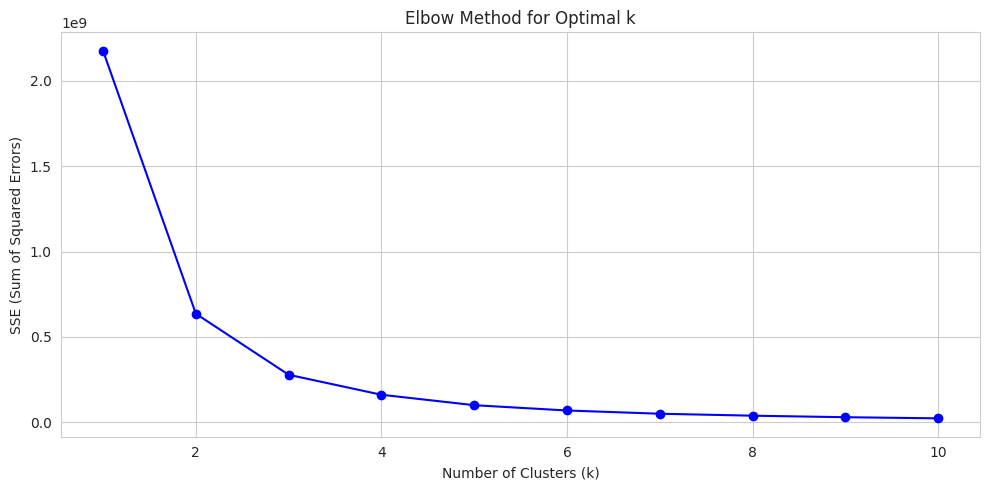

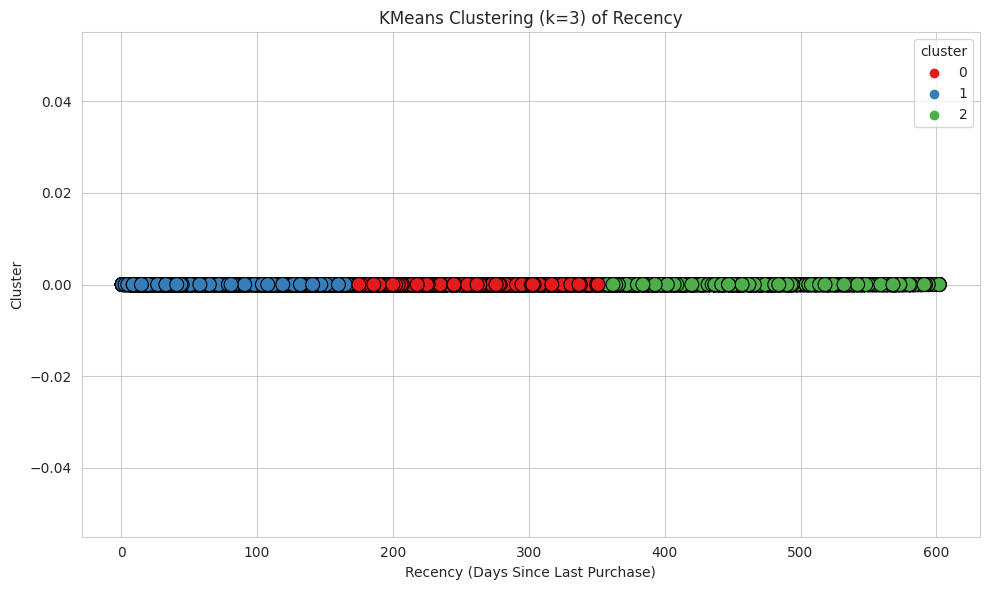

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=42).fit(recency[['recency']])
    sse[k] = kmeans.inertia_  # Calculate SSE (Sum of Squared Errors)
plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()), marker='o', color='b')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("SSE (Sum of Squared Errors)")
plt.title("Elbow Method for Optimal k")
plt.tight_layout()
plt.show()

k_optimal = 3
kmeans = KMeans(n_clusters=k_optimal, max_iter=1000, random_state=42)
recency['cluster'] = kmeans.fit_predict(recency[['recency']])

plt.figure(figsize=(10, 6))
sns.scatterplot(x=recency['recency'], y=[0]*len(recency), hue=recency['cluster'], palette='Set1', s=100, edgecolor='black')
plt.title(f"KMeans Clustering (k={k_optimal}) of Recency")
plt.xlabel('Recency (Days Since Last Purchase)')
plt.ylabel('Cluster')
plt.tight_layout()
plt.show()


Assign Recency label to each user

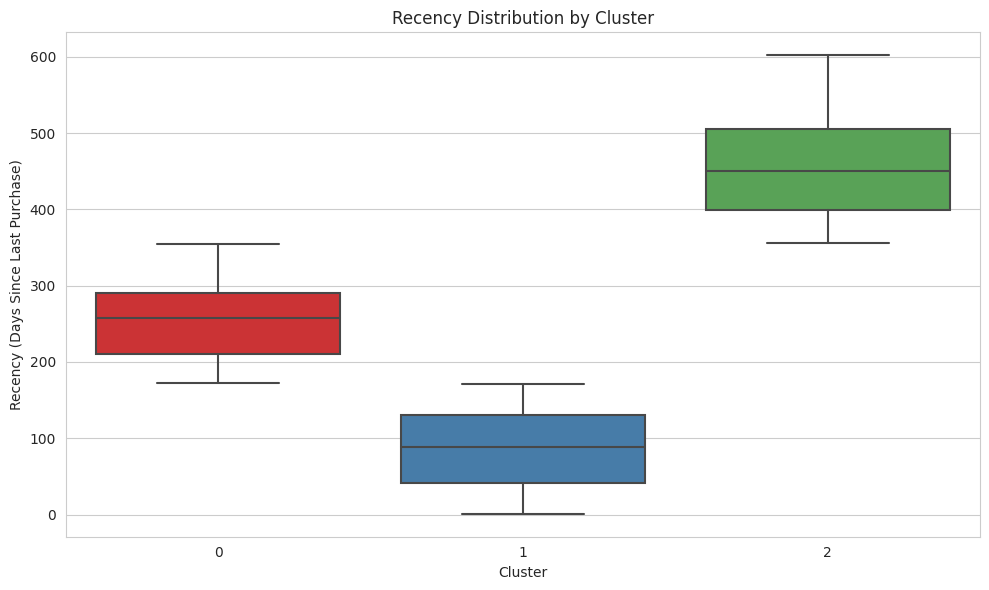


Descriptive Statistics for Recency by Cluster:
           count        mean        std    min    25%    50%    75%    max
cluster                                                                   
0        35921.0  254.974639  51.101954  172.0  211.0  258.0  291.0  355.0
1        36756.0   87.686038  49.737044    1.0   41.0   88.0  131.0  171.0
2        22444.0  455.045803  64.643616  356.0  399.0  450.0  506.0  602.0


In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score

recency_stats = recency.groupby('cluster')['recency'].describe()
styled_recency_stats = recency_stats.style.format("{:,.2f}") \
    .background_gradient(cmap="coolwarm") \
    .set_caption("Descriptive Statistics for Recency by Cluster") \
    .set_table_styles([{
        'selector': 'caption', 
        'props': [('font-size', '16px'), ('font-weight', 'bold')]
    }, {
        'selector': 'th', 
        'props': [('background-color', '#f0f0f0'), ('color', 'black'), ('font-weight', 'bold')]
    }, {
        'selector': 'td', 
        'props': [('text-align', 'center'), ('padding', '10px')]
    }])

styled_recency_stats

plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='recency', data=recency, palette='Set1')
plt.title("Recency Distribution by Cluster")
plt.xlabel('Cluster')
plt.ylabel('Recency (Days Since Last Purchase)')
plt.tight_layout()
plt.show()

print("\nDescriptive Statistics for Recency by Cluster:")
print(recency_stats)


In [ ]:
# Evaluate clustering performance using the Silhouette Score
silhouette_avg = silhouette_score(recency[['recency']], recency['cluster'])
print(f"Silhouette Score: {silhouette_avg:.2f}")


Silhouette Score: 0.58


#### **Assign clustered recency label to each user**

In [ ]:
df_recency_with_cluster = recency[['customer_unique_id', 'recency', 'cluster']]
print(df_recency_with_cluster.head())


                 customer_unique_id  recency  cluster
0  0000366f3b9a7992bf8c76cfdf3221e2      112        1
1  0000b849f77a49e4a4ce2b2a4ca5be3f      115        1
2  0000f46a3911fa3c0805444483337064      537        2
3  0000f6ccb0745a6a4b88665a16c9f078      321        0
4  0004aac84e0df4da2b147fca70cf8255      288        0


#### **2. Frequency**
    Purchase frequency

                 customer_unique_id  frequency
0  0000366f3b9a7992bf8c76cfdf3221e2          1
1  0000b849f77a49e4a4ce2b2a4ca5be3f          1
2  0000f46a3911fa3c0805444483337064          1
3  0000f6ccb0745a6a4b88665a16c9f078          1
4  0004aac84e0df4da2b147fca70cf8255          1


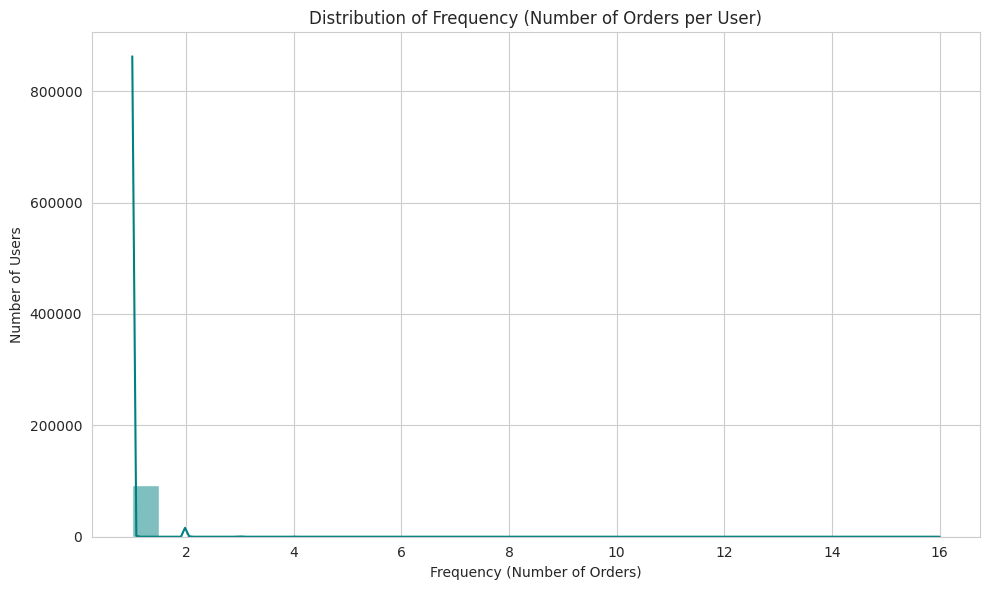

,count,mean,std,min,25%,50%,75%,max
frequency,"95,121.00",1.03,0.21,1.00,1.00,1.00,1.00,16.00


In [ ]:
# Calculate the purchase frequency for each user.
frequency = df_final.groupby('customer_unique_id').agg(
    frequency=('order_id', 'nunique')  # Calculate the number of orders for each user (i.e., purchase frequency).
).reset_index()
print(frequency.head())

plt.figure(figsize=(10, 6))
sns.histplot(frequency['frequency'], kde=True, color='teal', bins=30)
plt.title('Distribution of Frequency (Number of Orders per User)')
plt.xlabel('Frequency (Number of Orders)')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()

frequency_desc = frequency['frequency'].describe()

frequency_desc_df = frequency_desc.to_frame().T 

styled_table_frequency = frequency_desc_df.style.format("{:,.2f}") \
    .background_gradient(cmap="coolwarm") \
    .set_caption("Descriptive Statistics for Frequency") \
    .set_table_styles([{
        'selector': 'caption', 
        'props': [('font-size', '16px'), ('font-weight', 'bold')]
    }, {
        'selector': 'th',  
        'props': [('background-color', '#f0f0f0'), ('color', 'black'), ('font-weight', 'bold')]
    }, {
        'selector': 'td', 
        'props': [('text-align', 'center'), ('padding', '10px')]
    }])

styled_table_frequency


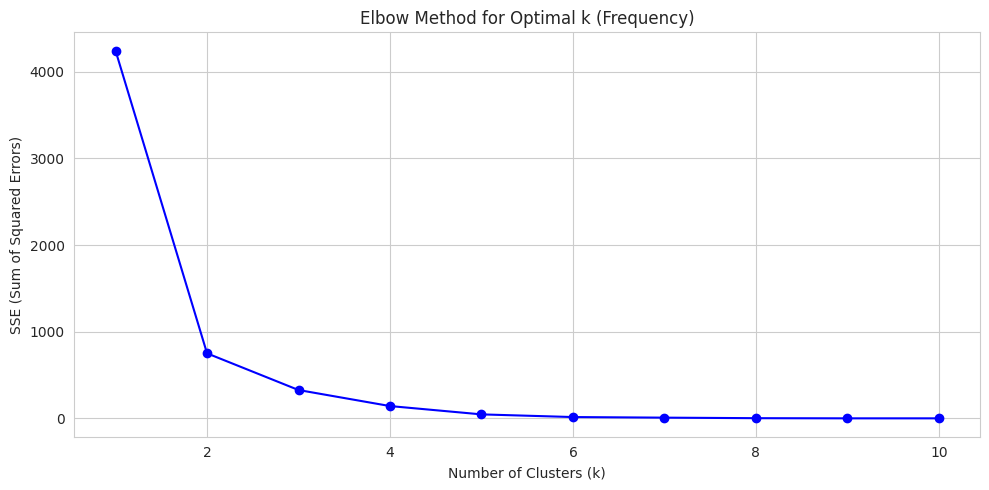

In [ ]:
sse_frequency = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=42).fit(frequency[['frequency']])
    sse_frequency[k] = kmeans.inertia_  # Calculate SSE (Sum of Squared Errors)

plt.figure(figsize=(10, 5))
plt.plot(list(sse_frequency.keys()), list(sse_frequency.values()), marker='o', color='b')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("SSE (Sum of Squared Errors)")
plt.title("Elbow Method for Optimal k (Frequency)")
plt.tight_layout()
plt.show()

                 customer_unique_id  frequency  cluster
0  0000366f3b9a7992bf8c76cfdf3221e2          1        0
1  0000b849f77a49e4a4ce2b2a4ca5be3f          1        0
2  0000f46a3911fa3c0805444483337064          1        0
3  0000f6ccb0745a6a4b88665a16c9f078          1        0
4  0004aac84e0df4da2b147fca70cf8255          1        0


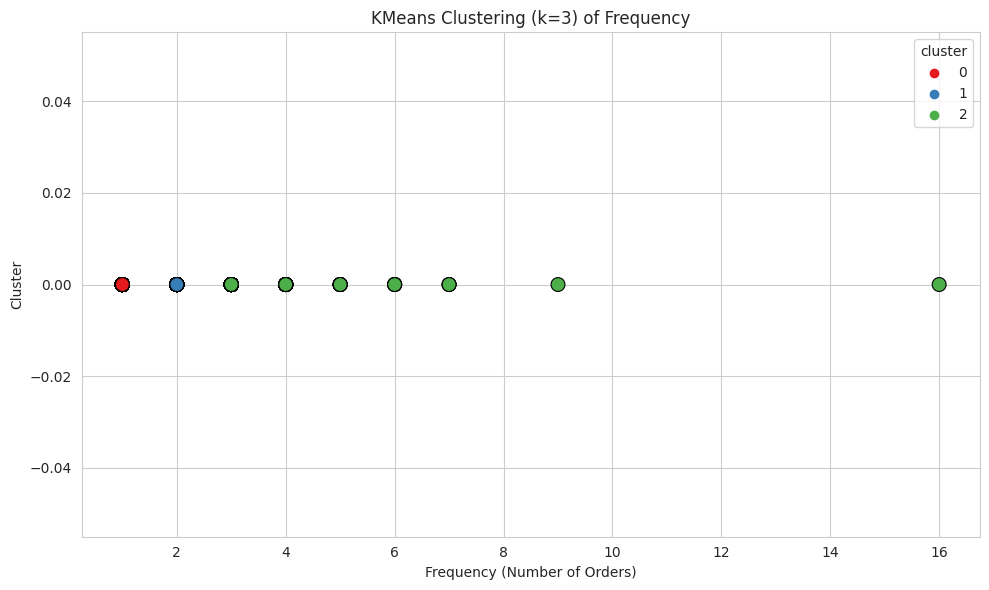

In [ ]:
k_optimal_frequency = 3

kmeans_frequency = KMeans(n_clusters=k_optimal_frequency, max_iter=1000, random_state=42)
frequency['cluster'] = kmeans_frequency.fit_predict(frequency[['frequency']])

print(frequency.head())

plt.figure(figsize=(10, 6))
sns.scatterplot(x=frequency['frequency'], y=[0]*len(frequency), hue=frequency['cluster'], palette='Set1', s=100, edgecolor='black')
plt.title(f"KMeans Clustering (k={k_optimal_frequency}) of Frequency")
plt.xlabel('Frequency (Number of Orders)')
plt.ylabel('Cluster')
plt.tight_layout()
plt.show()


In [ ]:
# Evaluate clustering performance using the Silhouette Score.
silhouette_avg_frequency = silhouette_score(frequency[['frequency']], frequency['cluster'])
print(f"Silhouette Score for k={k_optimal_frequency} (Frequency): {silhouette_avg_frequency:.2f}")


Silhouette Score for k=3 (Frequency): 1.00


In [ ]:
# Merge the frequency labels into df_recency_with_cluster
df_recency_with_frequency = df_recency_with_cluster.merge(frequency[['customer_unique_id', 'frequency', 'cluster']], 
                                                         on='customer_unique_id', 
                                                         how='left', 
                                                         suffixes=('_recency', '_frequency'))

# View the merged DataFrame
print(df_recency_with_frequency.head())


                 customer_unique_id  recency  cluster_recency  frequency  \
0  0000366f3b9a7992bf8c76cfdf3221e2      112                1          1   
1  0000b849f77a49e4a4ce2b2a4ca5be3f      115                1          1   
2  0000f46a3911fa3c0805444483337064      537                2          1   
3  0000f6ccb0745a6a4b88665a16c9f078      321                0          1   
4  0004aac84e0df4da2b147fca70cf8255      288                0          1   

   cluster_frequency  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  


#### **3. Monetary**
    Total spending amount

In [ ]:
# Calculate the total amount spent on each order by adding the product price and the shipping fee
df_final['order_total_price'] = df_final['price'] + df_final['freight_value']
# Aggregate the total spending amount for each user by user ID
monetary = df_final.groupby('customer_unique_id').agg(
    monetary=('order_total_price', 'sum')  # Sum up the total spending amount for each user
).reset_index()
print(monetary.head())



                 customer_unique_id  monetary
0  0000366f3b9a7992bf8c76cfdf3221e2    141.90
1  0000b849f77a49e4a4ce2b2a4ca5be3f     27.19
2  0000f46a3911fa3c0805444483337064     86.22
3  0000f6ccb0745a6a4b88665a16c9f078     43.62
4  0004aac84e0df4da2b147fca70cf8255    196.89


                 customer_unique_id  monetary
0  0000366f3b9a7992bf8c76cfdf3221e2    141.90
1  0000b849f77a49e4a4ce2b2a4ca5be3f     27.19
2  0000f46a3911fa3c0805444483337064     86.22
3  0000f6ccb0745a6a4b88665a16c9f078     43.62
4  0004aac84e0df4da2b147fca70cf8255    196.89


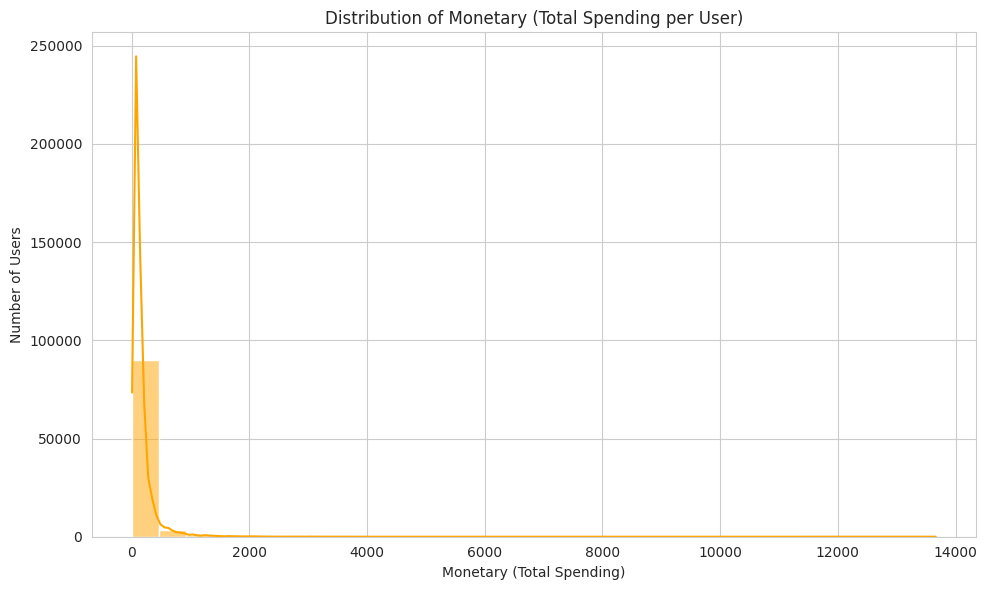

,count,mean,std,min,25%,50%,75%,max
monetary,"95,121.00",165.96,228.36,9.59,63.10,107.90,183.04,"13,664.08"


In [ ]:
monetary = df_final.groupby('customer_unique_id').agg(
    monetary=('order_total_price', 'sum')  # Sum up the total spending amount for each user
).reset_index()

print(monetary.head())

plt.figure(figsize=(10, 6))
sns.histplot(monetary['monetary'], kde=True, color='orange', bins=30)
plt.title('Distribution of Monetary (Total Spending per User)')
plt.xlabel('Monetary (Total Spending)')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()

monetary_desc = monetary['monetary'].describe()

monetary_desc_df = monetary_desc.to_frame().T  # Convert the data into a DataFrame and then transpose it.
styled_table_monetary = monetary_desc_df.style.format("{:,.2f}") \
    .background_gradient(cmap="coolwarm") \
    .set_caption("Descriptive Statistics for Monetary") \
    .set_table_styles([{
        'selector': 'caption', 
        'props': [('font-size', '16px'), ('font-weight', 'bold')]
    }, {
        'selector': 'th',  # Clean up column headers
        'props': [('background-color', '#f0f0f0'), ('color', 'black'), ('font-weight', 'bold')]
    }, {
        'selector': 'td',  # Format the table content for better presentation
        'props': [('text-align', 'center'), ('padding', '10px')]
    }])

styled_table_monetary

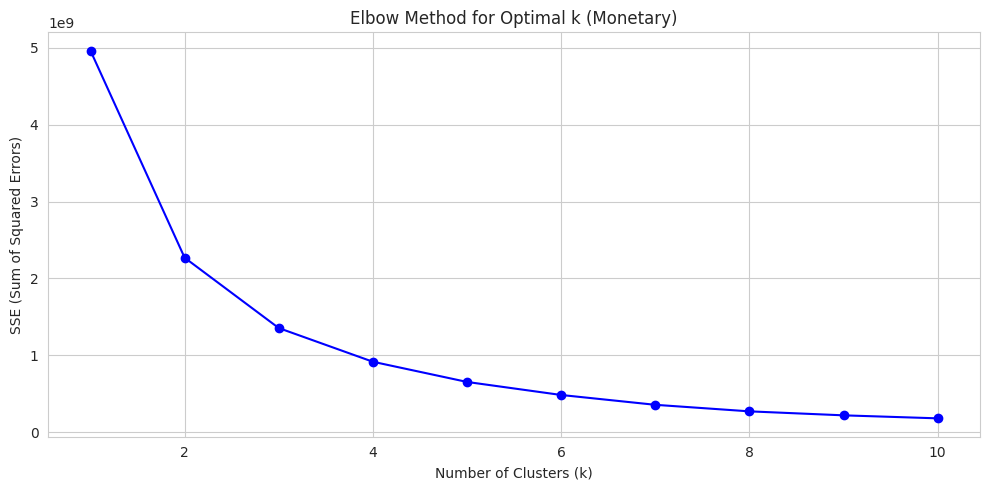

In [ ]:
sse_monetary = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=42).fit(monetary[['monetary']])
    sse_monetary[k] = kmeans.inertia_  # Calculate SSE (Sum of Squared Errors)

plt.figure(figsize=(10, 5))
plt.plot(list(sse_monetary.keys()), list(sse_monetary.values()), marker='o', color='b')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("SSE (Sum of Squared Errors)")
plt.title("Elbow Method for Optimal k (Monetary)")
plt.tight_layout()
plt.show()

                 customer_unique_id  monetary  cluster_monetary
0  0000366f3b9a7992bf8c76cfdf3221e2    141.90                 1
1  0000b849f77a49e4a4ce2b2a4ca5be3f     27.19                 1
2  0000f46a3911fa3c0805444483337064     86.22                 1
3  0000f6ccb0745a6a4b88665a16c9f078     43.62                 1
4  0004aac84e0df4da2b147fca70cf8255    196.89                 1


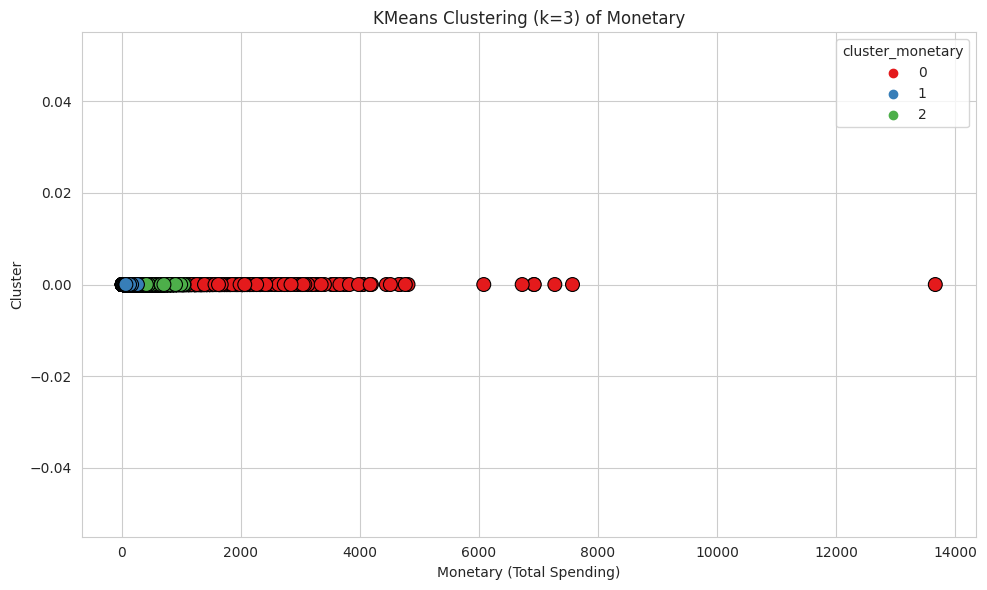

In [ ]:
k_optimal_monetary = 3

kmeans_monetary = KMeans(n_clusters=k_optimal_monetary, max_iter=1000, random_state=42)
monetary['cluster_monetary'] = kmeans_monetary.fit_predict(monetary[['monetary']])

print(monetary.head())

plt.figure(figsize=(10, 6))
sns.scatterplot(x=monetary['monetary'], y=[0]*len(monetary), hue=monetary['cluster_monetary'], palette='Set1', s=100, edgecolor='black')
plt.title(f"KMeans Clustering (k={k_optimal_monetary}) of Monetary")
plt.xlabel('Monetary (Total Spending)')
plt.ylabel('Cluster')
plt.tight_layout()
plt.show()

In [ ]:
silhouette_avg_monetary = silhouette_score(monetary[['monetary']], monetary['cluster_monetary'])
print(f"Silhouette Score for k={k_optimal_monetary} (Monetary): {silhouette_avg_monetary:.2f}")


Silhouette Score for k=3 (Monetary): 0.75


In [ ]:
df_recency_with_monetary = df_recency_with_frequency.merge(monetary[['customer_unique_id', 'monetary', 'cluster_monetary']], 
                                                           on='customer_unique_id', 
                                                           how='left', 
                                                           suffixes=('_recency', '_monetary'))
print(df_recency_with_monetary.head())

                 customer_unique_id  recency  cluster_recency  frequency  \
0  0000366f3b9a7992bf8c76cfdf3221e2      112                1          1   
1  0000b849f77a49e4a4ce2b2a4ca5be3f      115                1          1   
2  0000f46a3911fa3c0805444483337064      537                2          1   
3  0000f6ccb0745a6a4b88665a16c9f078      321                0          1   
4  0004aac84e0df4da2b147fca70cf8255      288                0          1   

   cluster_frequency  monetary  cluster_monetary  
0                  0    141.90                 1  
1                  0     27.19                 1  
2                  0     86.22                 1  
3                  0     43.62                 1  
4                  0    196.89                 1  


#### **Final summary table (users and their RFM labels)**

In [ ]:
df_cluster = df_recency_with_monetary
print(df_cluster.head(10))

                 customer_unique_id  recency  cluster_recency  frequency  \
0  0000366f3b9a7992bf8c76cfdf3221e2      112                1          1   
1  0000b849f77a49e4a4ce2b2a4ca5be3f      115                1          1   
2  0000f46a3911fa3c0805444483337064      537                2          1   
3  0000f6ccb0745a6a4b88665a16c9f078      321                0          1   
4  0004aac84e0df4da2b147fca70cf8255      288                0          1   
5  0004bd2a26a76fe21f786e4fbd80607f      146                1          1   
6  00050ab1314c0e55a6ca13cf7181fecf      132                1          1   
7  00053a61a98854899e70ed204dd4bafe      183                0          1   
8  0005e1862207bf6ccc02e4228effd9a0      543                2          1   
9  0005ef4cd20d2893f0d9fbd94d3c0d97      170                1          1   

   cluster_frequency  monetary  cluster_monetary  
0                  0    141.90                 1  
1                  0     27.19                 1  
2         

In [ ]:
# Ensure that the numerical columns are of type float or int.
df_cluster = df_cluster.apply(pd.to_numeric, errors='ignore')

styled_df_cluster = df_cluster.head(10).style.format("{:,.2f}", subset=['recency', 'frequency', 'monetary']) \
    .background_gradient(cmap="coolwarm") \
    .set_caption("Users with Recency, Frequency, and Monetary Clusters") \
    .set_table_styles([{
        'selector': 'caption', 
        'props': [('font-size', '16px'), ('font-weight', 'bold')]
    }, {
        'selector': 'th', 
        'props': [('background-color', '#f0f0f0'), ('color', 'black'), ('font-weight', 'bold')]
    }, {
        'selector': 'td',  
        'props': [('text-align', 'center'), ('padding', '10px')]
    }])

styled_df_cluster


,customer_unique_id,recency,cluster_recency,frequency,cluster_frequency,monetary,cluster_monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,112.00,1,1.00,0,141.90,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115.00,1,1.00,0,27.19,1
2,0000f46a3911fa3c0805444483337064,537.00,2,1.00,0,86.22,1
3,0000f6ccb0745a6a4b88665a16c9f078,321.00,0,1.00,0,43.62,1
4,0004aac84e0df4da2b147fca70cf8255,288.00,0,1.00,0,196.89,1
5,0004bd2a26a76fe21f786e4fbd80607f,146.00,1,1.00,0,166.98,1
6,00050ab1314c0e55a6ca13cf7181fecf,132.00,1,1.00,0,35.38,1
7,00053a61a98854899e70ed204dd4bafe,183.00,0,1.00,0,419.18,2
8,0005e1862207bf6ccc02e4228effd9a0,543.00,2,1.00,0,150.12,1
9,0005ef4cd20d2893f0d9fbd94d3c0d97,170.00,1,1.00,0,129.76,1


#### **Add a new column for the sum of the user's RFM cluster labels, as a new composite metric to distinguish users**

In [ ]:
# Calculate the 'RFM' column, which is the sum of the cluster labels for Recency, Frequency, and Monetary.
df_cluster['RFM'] = df_cluster['cluster_recency'] + df_cluster['cluster_frequency'] + df_cluster['cluster_monetary']

# Ensure that the numerical columns are of type float or int.
df_cluster = df_cluster.apply(pd.to_numeric, errors='ignore')

styled_df_cluster = df_cluster.head(10).style.format("{:,.2f}", subset=['recency', 'frequency', 'monetary', 'RFM']) \
    .background_gradient(cmap="coolwarm") \
    .set_caption("Users with Recency, Frequency, and Monetary Clusters and RFM") \
    .set_table_styles([{
        'selector': 'caption', 
        'props': [('font-size', '16px'), ('font-weight', 'bold')]
    }, {
        'selector': 'th', 
        'props': [('background-color', '#f0f0f0'), ('color', 'black'), ('font-weight', 'bold')]
    }, {
        'selector': 'td',
        'props': [('text-align', 'center'), ('padding', '10px')]
    }])

styled_df_cluster


,customer_unique_id,recency,cluster_recency,frequency,cluster_frequency,monetary,cluster_monetary,RFM
0,0000366f3b9a7992bf8c76cfdf3221e2,112.00,1,1.00,0,141.90,1,2.00
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115.00,1,1.00,0,27.19,1,2.00
2,0000f46a3911fa3c0805444483337064,537.00,2,1.00,0,86.22,1,3.00
3,0000f6ccb0745a6a4b88665a16c9f078,321.00,0,1.00,0,43.62,1,1.00
4,0004aac84e0df4da2b147fca70cf8255,288.00,0,1.00,0,196.89,1,1.00
5,0004bd2a26a76fe21f786e4fbd80607f,146.00,1,1.00,0,166.98,1,2.00
6,00050ab1314c0e55a6ca13cf7181fecf,132.00,1,1.00,0,35.38,1,2.00
7,00053a61a98854899e70ed204dd4bafe,183.00,0,1.00,0,419.18,2,2.00
8,0005e1862207bf6ccc02e4228effd9a0,543.00,2,1.00,0,150.12,1,3.00
9,0005ef4cd20d2893f0d9fbd94d3c0d97,170.00,1,1.00,0,129.76,1,2.00


In [ ]:
# Calculate the 'RFM' column, which is the sum of the cluster labels for Recency, Frequency, and Monetary
df_cluster['RFM'] = df_cluster['cluster_recency'] + df_cluster['cluster_frequency'] + df_cluster['cluster_monetary']

# Ensure that the numerical columns are of type float or int.
df_cluster = df_cluster.apply(pd.to_numeric, errors='ignore')
# Count the number of customers for each RFM combination
rfm_combination_stats = df_cluster.groupby(['RFM', 'cluster_recency', 'cluster_frequency', 'cluster_monetary']).size().reset_index(name='Customer Count')
# Calculate the proportion (percentage) of each combination
rfm_combination_stats['Percentage'] = (rfm_combination_stats['Customer Count'] / rfm_combination_stats['Customer Count'].sum()) * 100
rfm_combination_stats['Percentage'] = rfm_combination_stats['Percentage'].round(2).astype(str) + '%'

styled_rfm_combination_stats = rfm_combination_stats.style.format("{:,.0f}", subset=['Customer Count']) \
    .background_gradient(cmap="coolwarm") \
    .set_caption("RFM Combinations - Customer Count and Percentage") \
    .set_table_styles([{
        'selector': 'caption', 
        'props': [('font-size', '16px'), ('font-weight', 'bold')]
    }, {
        'selector': 'th',  
        'props': [('background-color', '#f0f0f0'), ('color', 'black'), ('font-weight', 'bold')]
    }, {
        'selector': 'td',  
        'props': [('text-align', 'center'), ('padding', '10px')]
    }])

styled_rfm_combination_stats


,RFM,cluster_recency,cluster_frequency,cluster_monetary,Customer Count,Percentage
0,0,0,0,0,269,0.28%
1,1,0,0,1,"31,268",32.87%
2,1,0,1,0,25,0.03%
3,1,1,0,0,373,0.39%
4,2,0,0,2,"3,251",3.42%
5,2,0,1,1,729,0.77%
6,2,0,2,0,8,0.01%
7,2,1,0,1,"31,848",33.48%
8,2,1,1,0,20,0.02%
9,2,2,0,0,243,0.26%


In [ ]:
# Calculate the ‘RFM’ column, which is the sum of the Recency, Frequency, and Monetary cluster labels
df_cluster['RFM'] = df_cluster['cluster_recency'] + df_cluster['cluster_frequency'] + df_cluster['cluster_monetary']

# Ensure that the numerical columns are of type float or int.
df_cluster = df_cluster.apply(pd.to_numeric, errors='ignore')

# Count the number of customers for each RFM value
rfm_stats = df_cluster['RFM'].value_counts().reset_index()

# Rename columns
rfm_stats.columns = ['RFM', 'Customer Count']
rfm_stats['Percentage'] = (rfm_stats['Customer Count'] / rfm_stats['Customer Count'].sum()) * 100
rfm_stats['Customer Count'] = rfm_stats['Customer Count'].astype(int)
rfm_stats['Percentage'] = rfm_stats['Percentage'].round(2)
rfm_stats['Percentage'] = rfm_stats['Percentage'].astype(str) + '%'
rfm_stats = rfm_stats.sort_values(by='RFM')
rfm_stats = rfm_stats.reset_index(drop=True)

styled_rfm_stats = rfm_stats.style.format("{:,.0f}", subset=['Customer Count']) \
    .background_gradient(cmap="coolwarm") \
    .set_caption("RFM Statistics - Customer Count and Percentage") \
    .set_table_styles([{
        'selector': 'caption', 
        'props': [('font-size', '16px'), ('font-weight', 'bold')]
    }, {
        'selector': 'th', 
        'props': [('background-color', '#f0f0f0'), ('color', 'black'), ('font-weight', 'bold')]
    }, {
        'selector': 'td',  
        'props': [('text-align', 'center'), ('padding', '10px')]
    }])
styled_rfm_stats


,RFM,Customer Count,Percentage
0,0,269,0.28%
1,1,"31,666",33.29%
2,2,"36,099",37.95%
3,3,"23,986",25.22%
4,4,"2,843",2.99%
5,5,243,0.26%
6,6,15,0.02%


The clustering effect of R, F, and M is evaluated by the Silhouette Score, which is an indicator used to assess the quality of clustering results. It measures the compactness of data points within their cluster and the separation from other clusters. The value ranges from [-1, 1], and the closer to 1, the better the clustering effect.  
R_silhouette = 0.58, F_silhouette = 1.00, M_silhouette = 0.75, clustering effect is good.

## **Analysis of RFM User Segmentation Results and Optimization Recommendations**

### **1. Layered result analysis**

RFM analysis classifies users based on the interval since last purchase (Recency), purchase frequency (Frequency), and total spending (Monetary), and develops differentiated operational strategies for different groups.

(1) **Important Value Users** (High R, High F, High M)
    Strategy: Avoid excessive marketing to prevent fatigue, provide responsive benefits, and collect feedback for improvement (personalized service).

    Goal: Increase customer lifetime value and loyalty (user stickiness)
(2) **Important Growth Users** (High R, Low F, High M)
    Strategy: These users have high value but different purchase frequencies. Use intelligent recommendation engines (recommend complementary products based on historical orders), improve algorithm logic, and set tiered reward plans to increase purchase frequency.

    Goal: Cultivate user consumption habits
(3) **Important Retention Users** (Low R, High F, High M)
    Strategy: Users whose last purchase was a long time ago but have certain loyalty. Actively maintain contact, increase retention rate, extend user activity cycle, and increase LTV. Improve recall rate and reduce costs to increase ROI (recalling old customers is cheaper than acquiring new ones).
    
(4) **Important Recovery Users** (Low R, Low F, High M)
    Last purchase was a long time ago, low purchase frequency, but high spending. These users are about to churn, so proactively contact them, investigate issues, and provide personalized remedies. Worth investing some cost to recover.

### **2. Key points for implementing RFM strategies**

**With the RFM model, companies can precisely invest resources in high-potential user groups, significantly improving operational efficiency.**

**Data Standardization**:
Define reasonable binning standards for R/F/M (such as dividing high/low thresholds by percentiles or business logic).
For example: R value can be layered by 30 days/90 days, F value by industry average.

**Dynamic Adjustment**:
Update RFM scores regularly (e.g., monthly) to reflect users' latest behavior.
Seasonal industries (such as e-commerce) should consider holiday fluctuations.

**Combine with Other Dimensions**:
Overlay user profiles (age, interests) or product categories to refine strategies.
For example: For high M users who buy baby products, push related new products.

**Effect Monitoring**:
Set conversion goals (such as conversion rate from growth users to value users), and optimize strategies through A/B testing.

**Humanized Operations**:
Demand first, think from the user's perspective; long-term value is greater than short-term conversion, improve customer LTV; avoid being too purposeful or rigid in development.